<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install tensorflow-addons
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 5.9 MB/s 
     |████████████████████████████████| 71 kB 7.4 MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp37-cp37m-linux_x86_64.whl size=2619374 sha256=8a022bd34a8c797316306f268985f42aee18004f4e2dd5d20b46f8e6ad3270fc
  Stored in directory: /root/.cache/pip/wheels/23/6d/58/90d8e44f8fd9f442de81992a427a5947a6e5f7b78cd65acd9a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=7ca550687bf9a3032d9a61075780c866f3a1c94229c3e12380f6467b26745571
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [3]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/KaggleImageData/UfukHocaVeri', output="output", seed=1337, ratio=(.7, 0.2, 0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 193 files [00:50,  3.80 files/s]


In [28]:
#to prevent below error that occur in the normalization step run this code
#jpeg::Uncompress failed. Invalid JPEG data or crop window. [[{{node decode_image/DecodeImage}}]] [Op:IteratorGetNext]
#I faced similar problem. there is a problem in some of your training data. you can use code below to check which jpeg image is corrupted and delete it.
from struct import unpack
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []
paths=["0", "1", "2", "3", "4"]
for i in paths:
  path="/content/gdrive/MyDrive/KaggleImageData/allDataCLAHE/"+i
  for img in os.listdir(path):
    image = os.path.join(path,img)
    image = JPEG(image) 
    try:
      image.decode()   
    except:
      bads.append(img)
  for name in bads:
    print(path, name)
    os.remove(os.path.join(path,name))

In [4]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val']) # Görselleri dataframe'e yazar target'la birlikte. Görselleri array olarak tutar.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Görselleri normalize eder (x = x / 255) targetlara da one hot encoding yapar (1,0,0)
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = tf.keras.applications.vgg16.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [6]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout

input_tensor = K.Input(shape=(32, 32, 3)) # Input olarak girecek yapıyı oluşturur
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor) # lambda list comp. gibi input_tensordaki tüm image'ı resize ediyor
base_model = VGG16(include_top=False,
                    weights='imagenet',
                    input_tensor=resized_images,
                    input_shape=(224, 224, 3),
                    pooling='max',
                    classes=5)

output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()# no data augmentation for train set we did that in seperate code for class 1,3 and 4
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [9]:
from tensorflow.keras import layers, models
from keras.models import Sequential, Model

def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch = 32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('VGG_16.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [10]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [11]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.37838

Epoch 3: val_accuracy improved from 0.37838 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.43243

Epoch 6: val_accuracy did not improve from 0.43243
Epoch 6: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 13.5728 - accuracy: 0.3514

LOSS:	13.57278060913086 	 ACCURACY:	0.3513513505458832
[13.57278060913086, 0.3513513505458832]



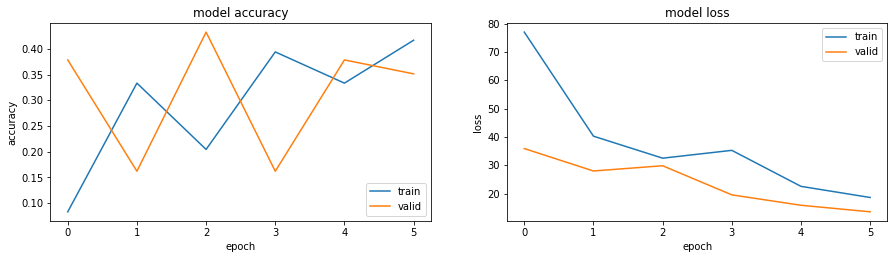


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 13.5728 - accuracy: 0.3514

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 35.1945 - accuracy: 0.1622

LOSS:	35.194549560546875 	 ACCURACY:	0.1621621549129486
[35.194549560546875, 0.1621621549129486]



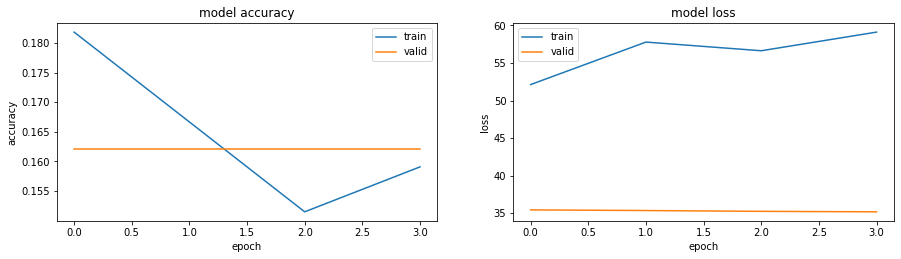


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 13.5728 - accuracy: 0.3514

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy did not improve from 0.43243
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 2.6408 - accuracy: 0.4324

LOSS:	2.6407663822174072 	 ACCURACY:	0.4324324429035187
[2.6407663822174072, 0.4324324429035187]



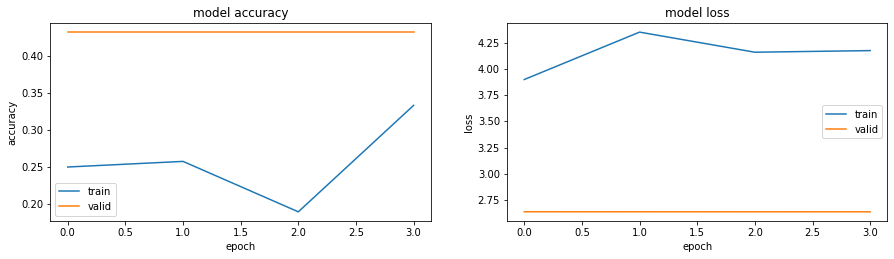


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 1.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.6408 - accuracy: 0.4324

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy did not improve from 0.43243
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 41.5986 - accuracy: 0.4054

LOSS:	41.598594665527344 	 ACCURACY:	0.4054054021835327
[41.598594665527344, 0.4054054021835327]



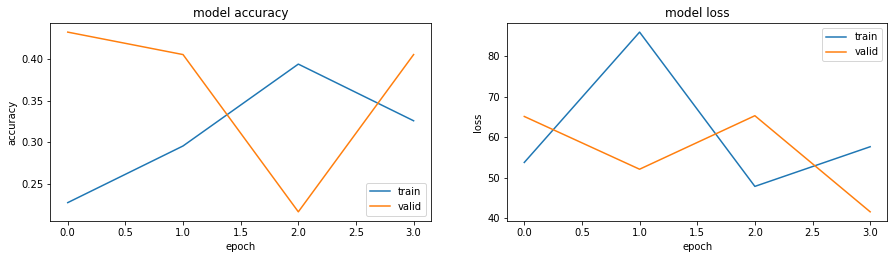


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 2.6408 - accuracy: 0.4324

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 90.7754 - accuracy: 0.1351

LOSS:	90.77537536621094 	 ACCURACY:	0.13513512909412384
[90.77537536621094, 0.13513512909412384]



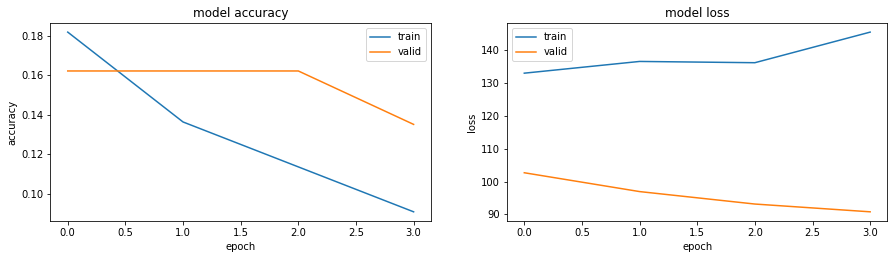




Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.6408 - accuracy: 0.4324

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.21622 to 0.37838, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.37838 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.43243

Epoch 6: val_accuracy did not improve from 0.43243
Epoch 6: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 120.6953 - accuracy: 0.3784

LOSS:	120.69529724121094 	 ACCURACY:	0.37837839126586914
[120.69529724121094, 0.37837839126586914]



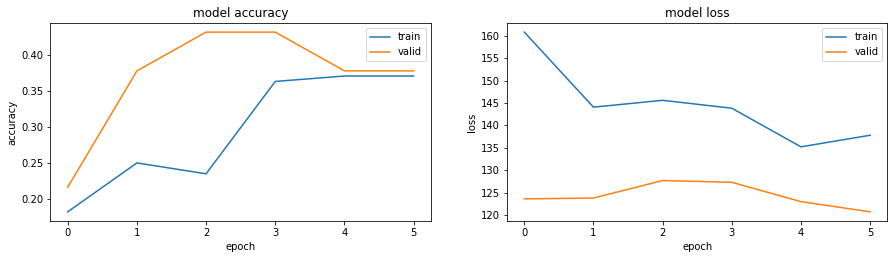


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 2.6408 - accuracy: 0.4324

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: val_accuracy improved from 0.40541 to 0.48649, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.48649

Epoch 5: val_accuracy improved from 0.48649 to 0.54054, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.54054

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.54054

Epoch 8: val_accuracy did not improve from 0.54054
Epoch 8: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 25.8742 - accuracy: 0.4054

LOSS:	25.87420082092285 	 ACCURACY:	0.4054054021835327
[25.87420082092285, 0.4054054021835327]



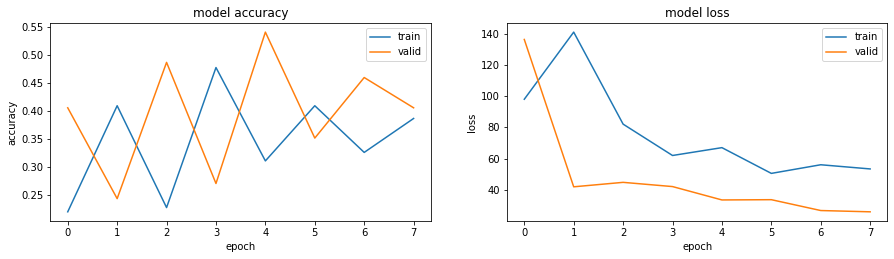


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 2.6408 - accuracy: 0.4324

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.16216 to 0.18919, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy improved from 0.18919 to 0.24324, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.24324

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 6: val_accuracy did not improve from 0.24324

Epoch 7: val_accuracy improved from 0.24324 to 0.27027, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.27027

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.5999998544866682e-06.

Epoch 9: val_accuracy did not improve from 0.27027

Epoch 10: val_accuracy improved from 0.27027 to 0.29730, saving model to VGG_16.h5



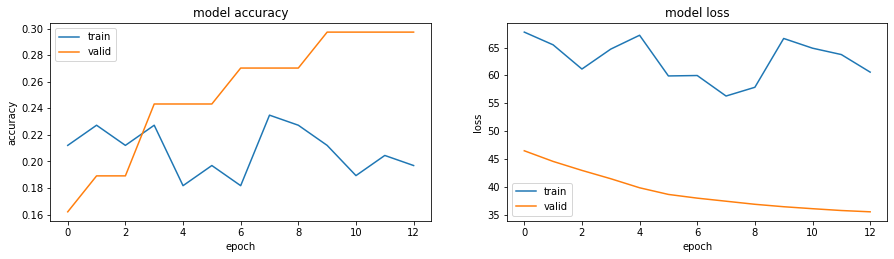


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 3.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 1s 10ms/step - loss: 2.6408 - accuracy: 0.4324

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 15ms/step - loss: 56.7023 - accuracy: 0.1081

LOSS:	56.702327728271484 	 ACCURACY:	0.10810811072587967
[56.702327728271484, 0.10810811072587967]



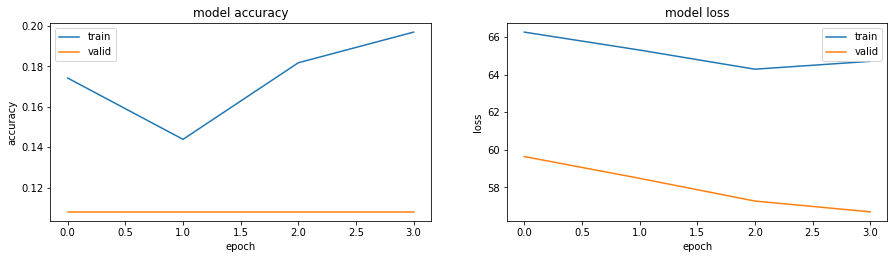


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 2.6408 - accuracy: 0.4324

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.37838

Epoch 3: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.43243 to 0.48649, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.48649

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.48649

Epoch 8: val_accuracy did not improve from 0.48649
Epoch 8: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 27.1071 - accuracy: 0.4865

LOSS:	27.107114791870117 	 ACCURACY:	0.4864864945411682
[27.107114791870117, 0.4864864945411682]



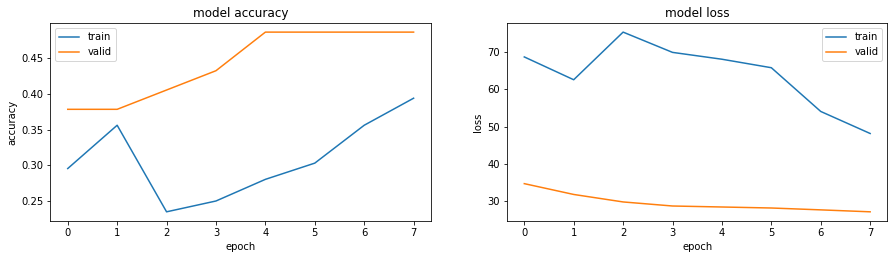


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 19ms/step - loss: 27.1071 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 12.4081 - accuracy: 0.1622

LOSS:	12.408136367797852 	 ACCURACY:	0.1621621549129486
[12.408136367797852, 0.1621621549129486]



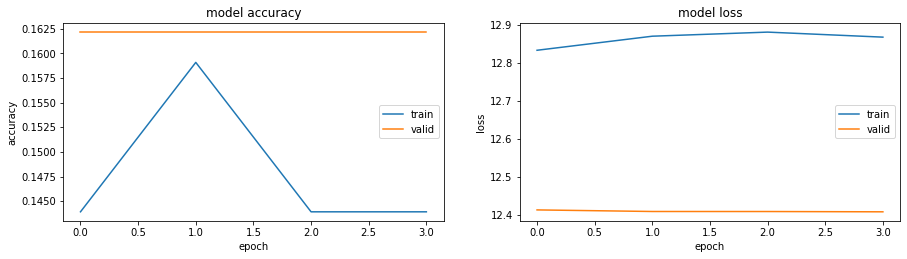


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 27.1071 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.48649, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.48649

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.48649

Epoch 5: val_accuracy did not improve from 0.48649
Epoch 5: early stopping
2/2 [==============================] - 0s 14ms/step - loss: 29.5727 - accuracy: 0.4865

LOSS:	29.572711944580078 	 ACCURACY:	0.4864864945411682
[29.572711944580078, 0.4864864945411682]



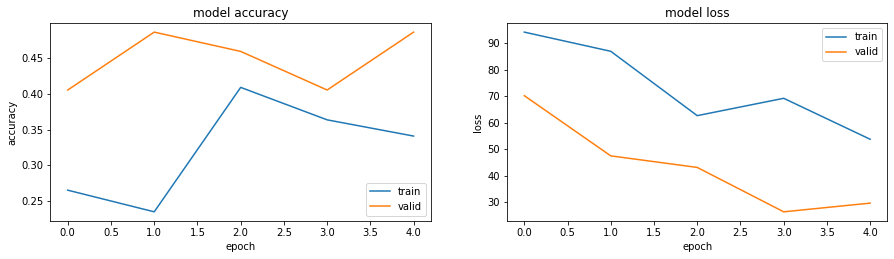


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 27.1071 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 14ms/step - loss: 104.7289 - accuracy: 0.4054

LOSS:	104.72893524169922 	 ACCURACY:	0.4054054021835327
[104.72893524169922, 0.4054054021835327]



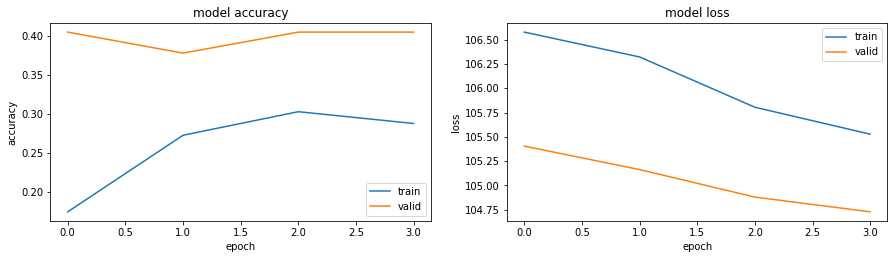


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 27.1071 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: val_accuracy improved from 0.24324 to 0.29730, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.29730 to 0.35135, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.35135

Epoch 6: val_accuracy improved from 0.35135 to 0.37838, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.37838

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.37838

Epoch 9: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.40541

Epoch 11: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_

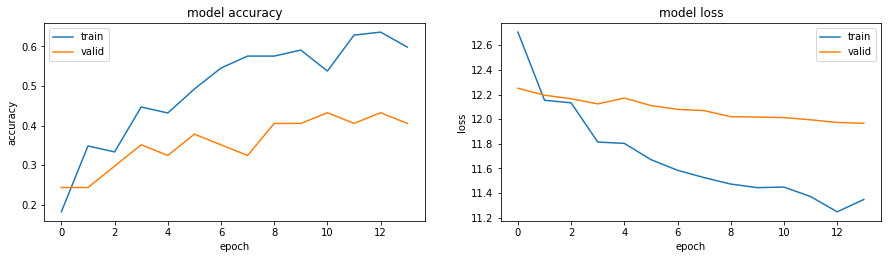


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 27.1071 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.32432, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.32432

Epoch 4: val_accuracy improved from 0.32432 to 0.35135, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.35135

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.35135

Epoch 7: val_accuracy did not improve from 0.35135
Epoch 7: early stopping
2/2 [==============================] - 0s 18ms/step - loss: 124.3062 - accuracy: 0.3514

LOSS:	124.30624389648438 	 ACCURACY:	0.3513513505458832
[124.30624389648438, 0.3513513505458832]



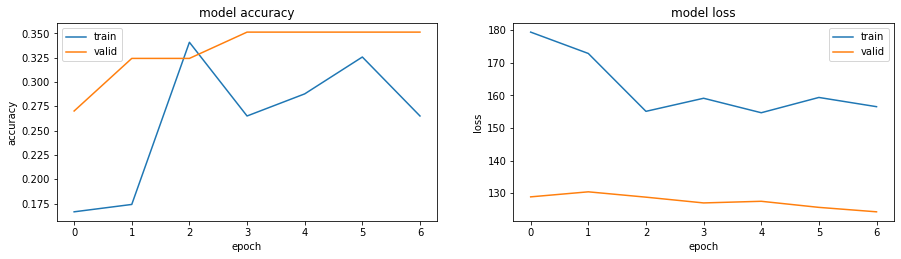


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 3.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 27.1071 - accuracy: 0.4865

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.40541 to 0.51351, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.51351

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.51351

Epoch 6: val_accuracy improved from 0.51351 to 0.59459, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.59459

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.59459

Epoch 9: val_accuracy did not improve from 0.59459
Epoch 9: early stopping
2/2 [==============================] - 0s 15ms/step - loss: 1

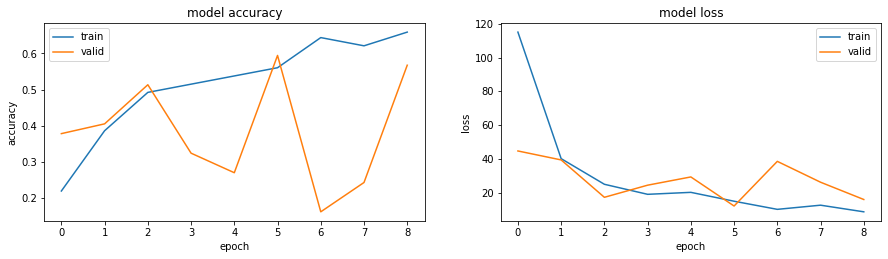


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: val_accuracy improved from 0.40541 to 0.51351, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.51351

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.51351

Epoch 6: val_accuracy did not improve from 0.51351
Epoch 6: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 24.4725 - accuracy: 0.4324

LOSS:	24.47246551513672 	 ACCURACY:	0.4324324429035187
[24.47246551513672, 0.4324324429035187]



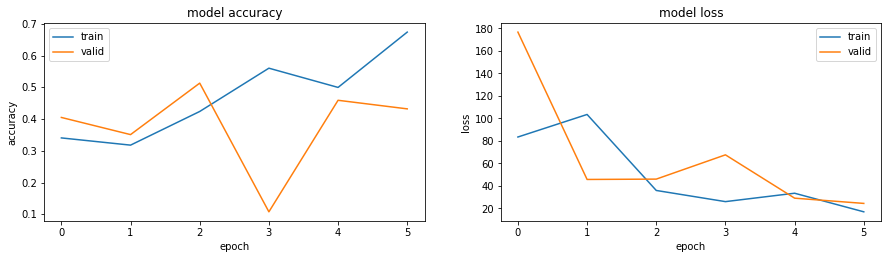


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 15ms/step - loss: 56.7949 - accuracy: 0.2162

LOSS:	56.7949333190918 	 ACCURACY:	0.21621622145175934
[56.7949333190918, 0.21621622145175934]



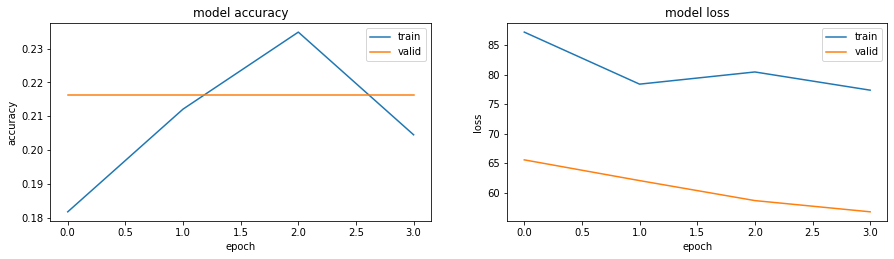


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.43243

Epoch 3: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.45946

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 5: val_accuracy did not improve from 0.45946

Epoch 6: val_accuracy did not improve from 0.45946
Epoch 6: early stopping
2/2 [==============================] - 0s 15ms/step - loss: 38.2698 - accuracy: 0.4324

LOSS:	38.26980209350586 	 ACCURACY:	0.4324324429035187
[38.26980209350586, 0.4324324429035187]



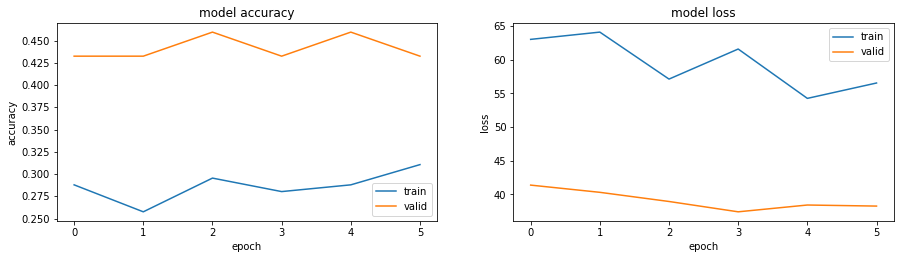


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 59.6540 - accuracy: 0.2432

LOSS:	59.654014587402344 	 ACCURACY:	0.2432432472705841
[59.654014587402344, 0.2432432472705841]



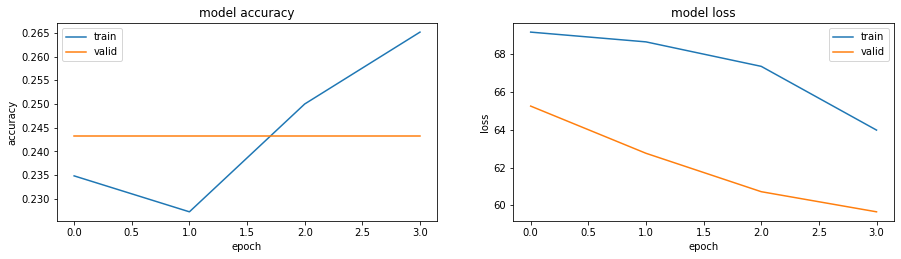


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 5.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13514 to 0.16216, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 4: val_accuracy did not improve from 0.16216

Epoch 5: val_accuracy improved from 0.16216 to 0.18919, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.18919 to 0.21622, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.21622

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.5999998544866682e-06.

Epoch 8: val_accuracy did not improve from 0.21622

Epoch 9: val_accuracy did not improve from 0.21622
Epoch 9: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 13

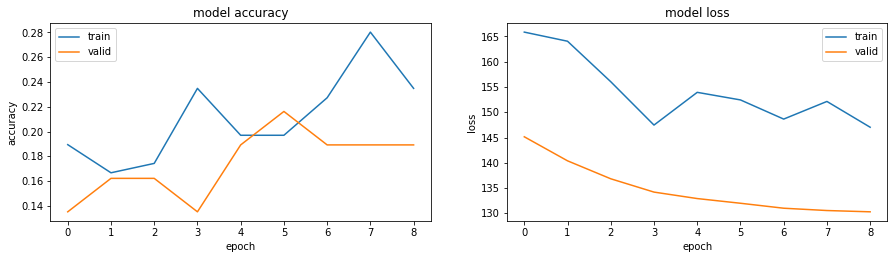


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13514 to 0.18919, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.18919 to 0.27027, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.27027 to 0.29730, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.29730 to 0.32432, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.32432

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.32432

Epoch 8: val_accuracy improved from 0.32432 to 0.35135, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.35135 to 0.37838, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.37838

Epoch 11: Reduce

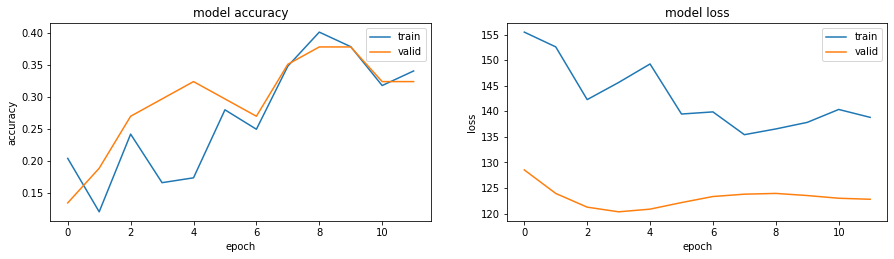


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 54.8248 - accuracy: 0.1351

LOSS:	54.824806213378906 	 ACCURACY:	0.13513512909412384
[54.824806213378906, 0.13513512909412384]



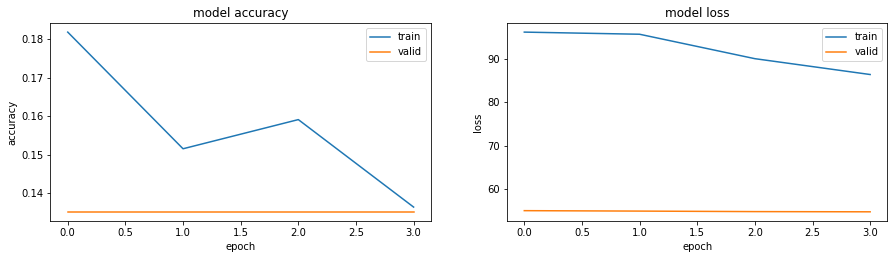


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 107.2076 - accuracy: 0.1622

LOSS:	107.20759582519531 	 ACCURACY:	0.1621621549129486
[107.20759582519531, 0.1621621549129486]



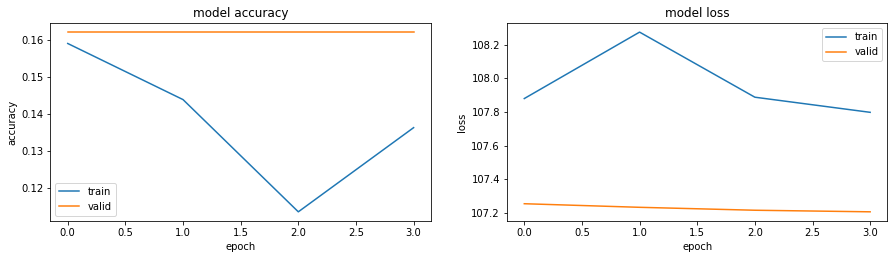


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13514 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy did not improve from 0.40541
Epoch 5: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 85.2915 - accuracy: 0.1351

LOSS:	85.29145050048828 	 ACCURACY:	0.13513512909412384
[85.29145050048828, 0.13513512909412384]



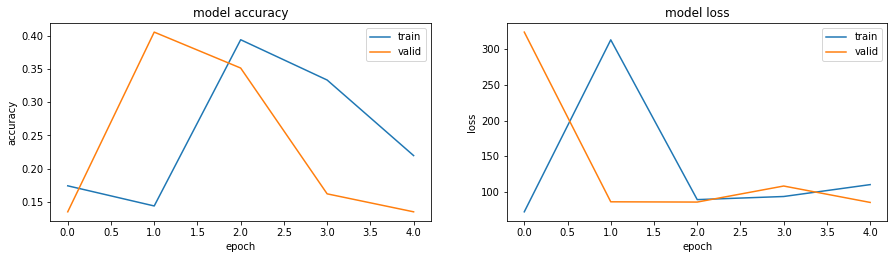


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.32432, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.32432

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.32432

Epoch 4: val_accuracy improved from 0.32432 to 0.43243, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: val_accuracy improved from 0.45946 to 0.54054, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.54054

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 9: val_accuracy did not improve from 0.54054

Epoch 10: val_accuracy did not improve from 0.54054
Epoch 10: early stopping
2/2 [===

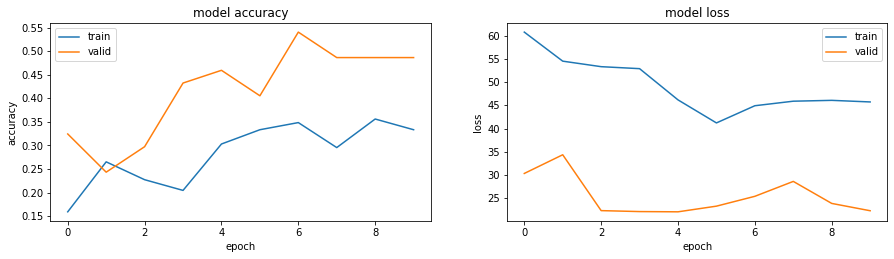


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.29730, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.29730 to 0.32432, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.32432 to 0.35135, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.35135

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.35135

Epoch 6: val_accuracy improved from 0.35135 to 0.37838, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.37838

Epoch 8: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.40541

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 10: val_accuracy did not improve from 0.40541


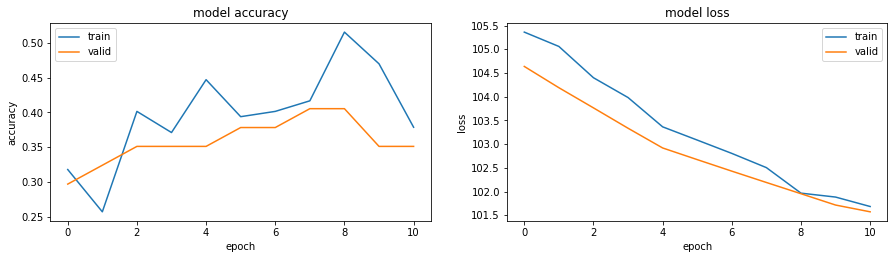


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.29730, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.29730 to 0.40541, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy did not improve from 0.40541
Epoch 5: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 42.3922 - accuracy: 0.3784

LOSS:	42.39219665527344 	 ACCURACY:	0.37837839126586914
[42.39219665527344, 0.37837839126586914]



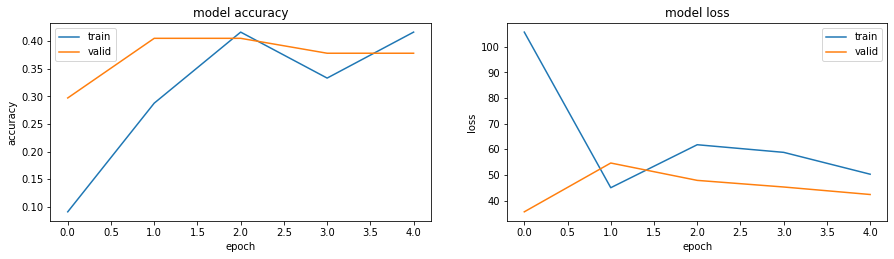


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.18919 to 0.21622, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 4: val_accuracy did not improve from 0.21622

Epoch 5: val_accuracy did not improve from 0.21622
Epoch 5: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 104.9074 - accuracy: 0.2162

LOSS:	104.90735626220703 	 ACCURACY:	0.21621622145175934
[104.90735626220703, 0.21621622145175934]



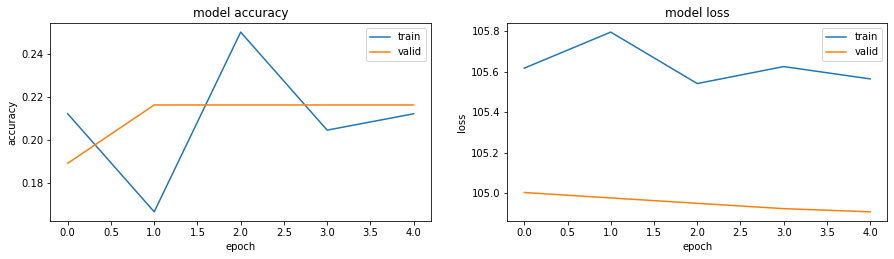


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.43243 to 0.54054, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.54054

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.54054

Epoch 6: val_accuracy did not improve from 0.54054
Epoch 6: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 30.8974 - accuracy: 0.4865

LOSS:	30.897428512573242 	 ACCURACY:	0.4864864945411682
[30.897428512573242, 0.4864864945411682]



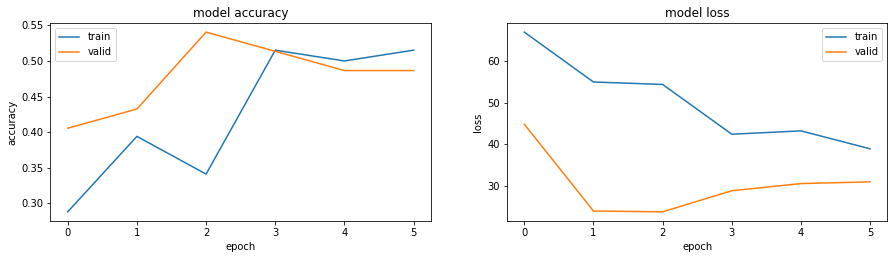


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 2.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy improved from 0.40541 to 0.48649, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.48649

Epoch 6: val_accuracy improved from 0.48649 to 0.56757, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.56757

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.56757

Epoch 9: val_accuracy did not improve from 0.56757
Epoch 9: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 11.3877 - accuracy: 0.4865

LOSS:	

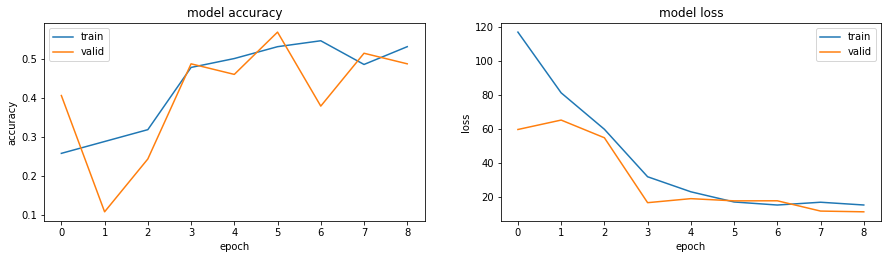


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy improved from 0.24324 to 0.29730, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.29730 to 0.45946, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: val_accuracy improved from 0.45946 to 0.54054, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.54054

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.54054

Epoch 10: val_accuracy did not improve from 0.54054
Epoch 10: early stopping
2/2 [==

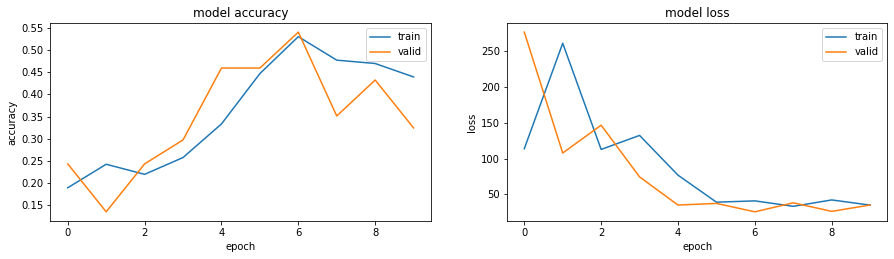


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 14ms/step - loss: 147.7911 - accuracy: 0.1081

LOSS:	147.7911376953125 	 ACCURACY:	0.10810811072587967
[147.7911376953125, 0.10810811072587967]



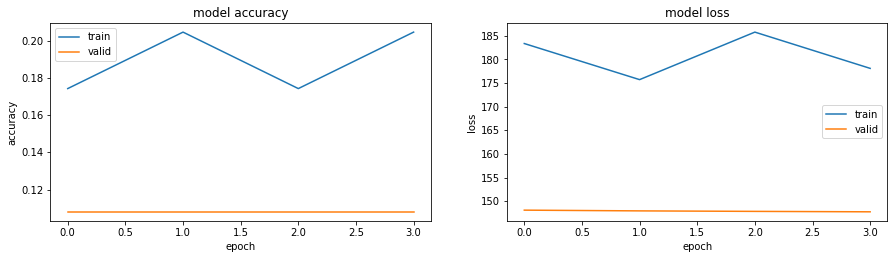


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.35135 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.45946 to 0.51351, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.51351 to 0.54054, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.54054

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.54054

Epoch 8: val_accuracy did not improve from 0.54054
Epoch 8: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 21.6869 - accuracy: 0.5135

LOSS:	21.686893463134766 	 ACCURACY:	0.5135135054588318
[21.686893463134

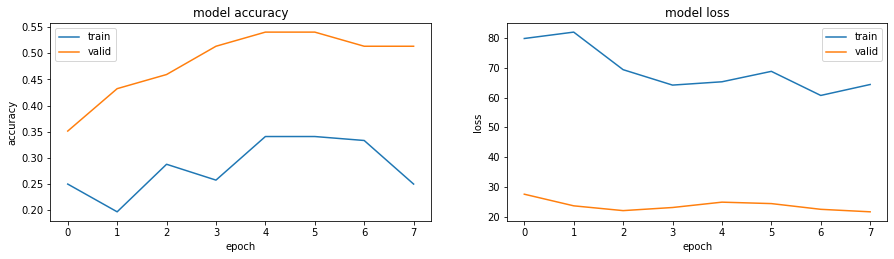


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 3.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.43243 to 0.48649, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.48649 to 0.54054, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.54054

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.54054

Epoch 6: val_accuracy did not improve from 0.54054
Epoch 6: early stopping
2/2 [==============================] - 0s 14ms/step - loss: 20.1747 - accuracy: 0.5405

LOSS:	20.17474937438965 	 ACCURACY:	0.5405405163764954
[20.17474937438965, 0.5405405163764954]



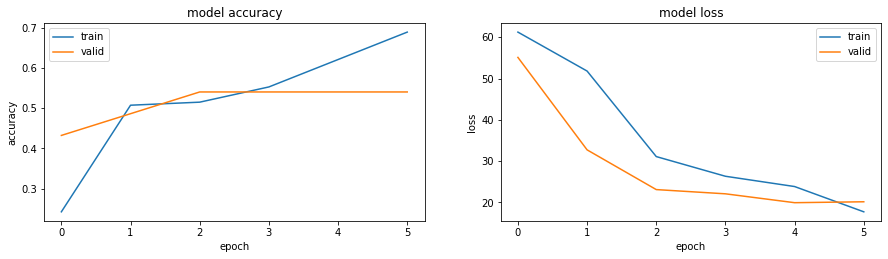


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.43243 to 0.48649, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.48649 to 0.56757, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.56757

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.56757

Epoch 6: val_accuracy did not improve from 0.56757
Epoch 6: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 9.0084 - accuracy: 0.5405

LOSS:	9.008440971374512 	 ACCURACY:	0.5405405163764954
[9.008440971374512, 0.5405405163764954]



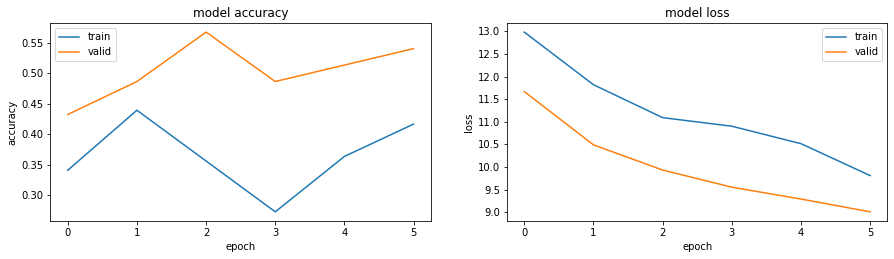


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.10811 to 0.16216, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.16216 to 0.18919, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.18919 to 0.21622, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.21622

Epoch 6: val_accuracy improved from 0.21622 to 0.24324, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.24324 to 0.29730, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.29730 to 0.32432, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.32432

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 10: val_accuracy did not improve from 0.32432

Epoch 11: val_a

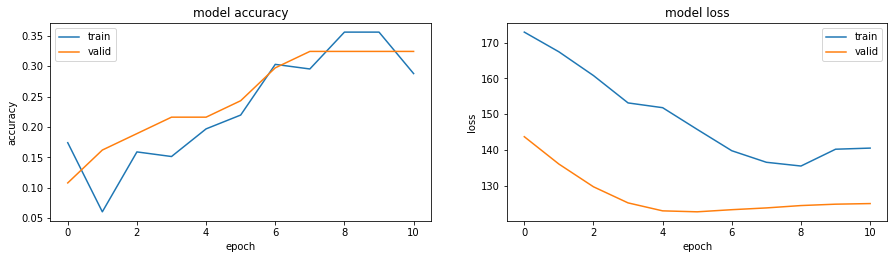


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 14ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.29730, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.29730

Epoch 3: val_accuracy improved from 0.29730 to 0.32432, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.32432 to 0.35135, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.35135 to 0.37838, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.37838

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.37838

Epoch 8: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.40541

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 10: val_accuracy did not improve from 0.40541


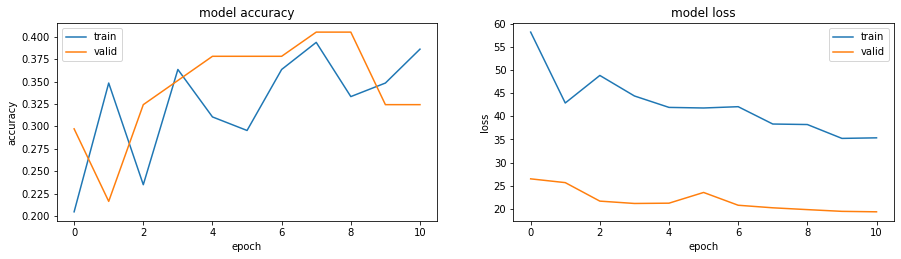


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 56.9708 - accuracy: 0.2432

LOSS:	56.970829010009766 	 ACCURACY:	0.2432432472705841
[56.970829010009766, 0.2432432472705841]



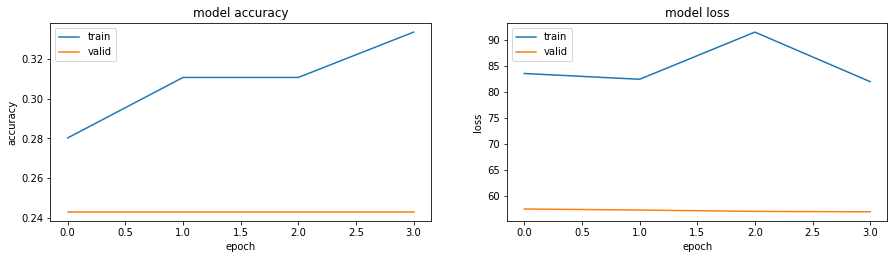


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.48649, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.48649

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.48649

Epoch 4: val_accuracy did not improve from 0.48649
Epoch 4: early stopping
2/2 [==============================] - 0s 14ms/step - loss: 105.1027 - accuracy: 0.4865

LOSS:	105.10269927978516 	 ACCURACY:	0.4864864945411682
[105.10269927978516, 0.4864864945411682]



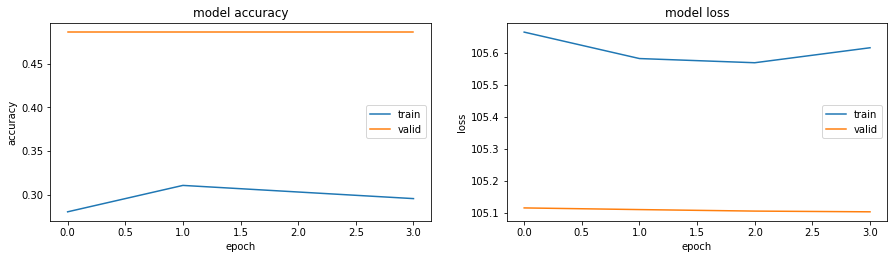


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 49.2352 - accuracy: 0.1892

LOSS:	49.235198974609375 	 ACCURACY:	0.18918919563293457
[49.235198974609375, 0.18918919563293457]



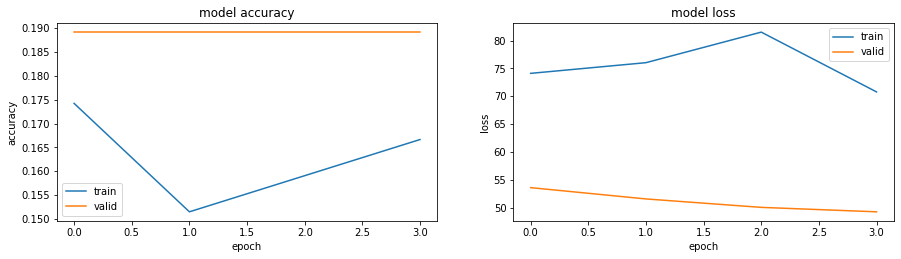


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 7.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: val_accuracy improved from 0.16216 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.45946

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: val_accuracy did not improve from 0.45946
Epoch 7: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 42.1718 - accuracy: 0.4595

LOSS:	42.171775817871094 	 ACCURACY:	0.45945945382118225
[42.171775817871094, 0.45945945382118225]



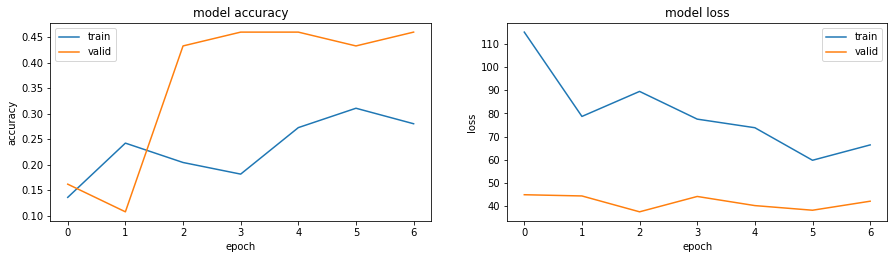


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.37838

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.37838

Epoch 4: val_accuracy did not improve from 0.37838
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 126.4728 - accuracy: 0.3784

LOSS:	126.47282409667969 	 ACCURACY:	0.37837839126586914
[126.47282409667969, 0.37837839126586914]



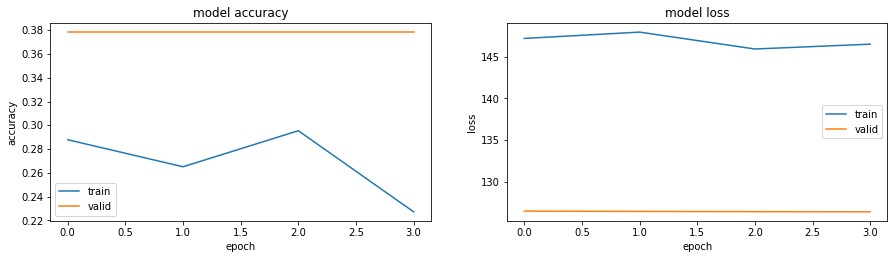


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 3.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.45946, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.45946

Epoch 3: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.51351

Epoch 6: val_accuracy improved from 0.51351 to 0.56757, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.56757

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.56757

Epoch 9: val_accuracy did not improve from 0.56757
Epoch 9: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 38.5415 - accuracy: 0.5405

LOSS:	38.54152297973633 	 ACCURACY:	0.5405405163764

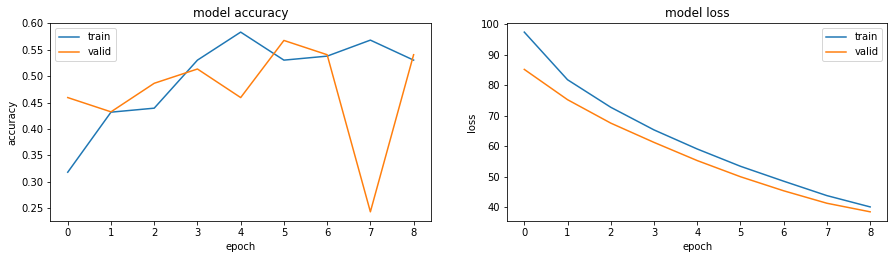


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.37838, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.37838 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.45946

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.45946

Epoch 6: val_accuracy did not improve from 0.45946
Epoch 6: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 38.8286 - accuracy: 0.3784

LOSS:	38.82855987548828 	 ACCURACY:	0.37837839126586914
[38.82855987548828, 0.37837839126586914]



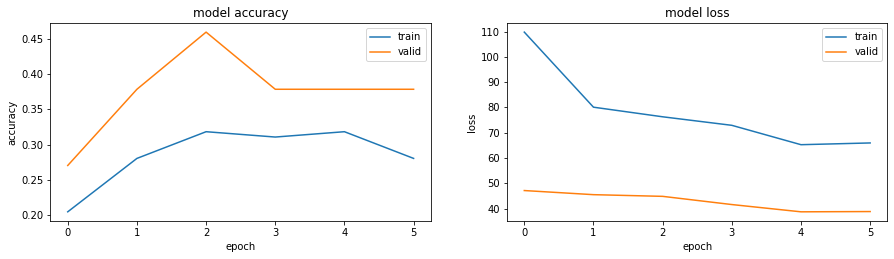


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 13.2396 - accuracy: 0.1351

LOSS:	13.23962688446045 	 ACCURACY:	0.13513512909412384
[13.23962688446045, 0.13513512909412384]



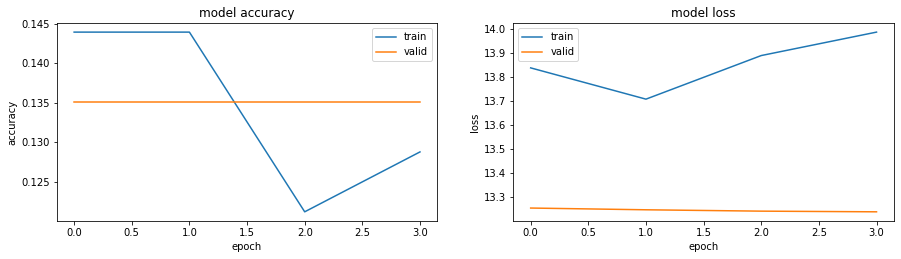


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.37838, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.37838

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.37838

Epoch 4: val_accuracy did not improve from 0.37838
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 104.5808 - accuracy: 0.3514

LOSS:	104.58075714111328 	 ACCURACY:	0.3513513505458832
[104.58075714111328, 0.3513513505458832]



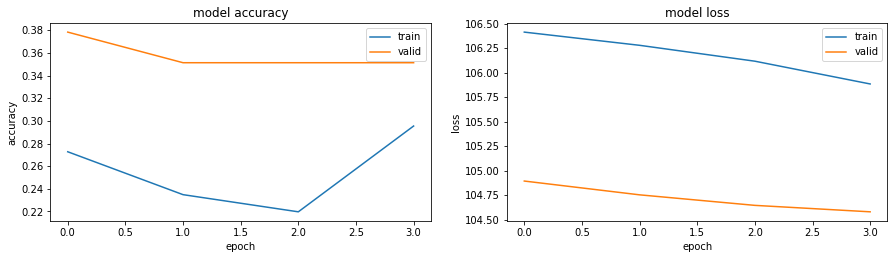


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.27027

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.27027

Epoch 4: val_accuracy did not improve from 0.27027
Epoch 4: early stopping
2/2 [==============================] - 0s 14ms/step - loss: 3.0860 - accuracy: 0.2703

LOSS:	3.0860140323638916 	 ACCURACY:	0.2702702581882477
[3.0860140323638916, 0.2702702581882477]



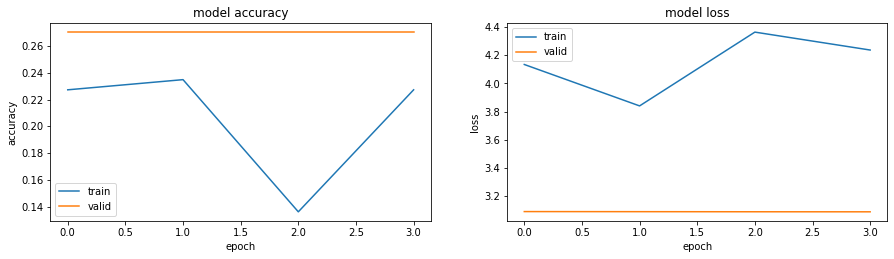


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: val_accuracy improved from 0.21622 to 0.24324, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.24324 to 0.35135, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.35135 to 0.40541, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.40541

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.40541

Epoch 8: val_accuracy did not improve from 0.40541
Epoch 8: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 11.8142 - accuracy: 0.3784

LOSS:	11.814218521118164 	 ACCURACY:	0.37837839126586914
[11.814218521118164, 0.37837839126586914]



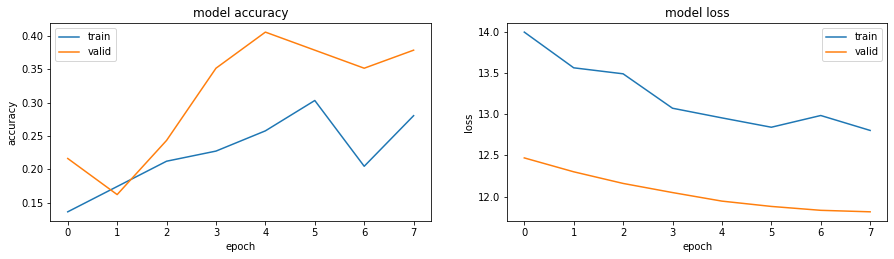


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy improved from 0.13514 to 0.16216, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.16216

Epoch 6: ReduceLROnPlateau reducing learning rate to 3.5999998544866682e-06.

Epoch 6: val_accuracy did not improve from 0.16216

Epoch 7: val_accuracy improved from 0.16216 to 0.18919, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.18919

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.159999939976842e-06.

Epoch 9: val_accuracy did not improve from 0.18919

Epoch 10: val_accuracy improved from 

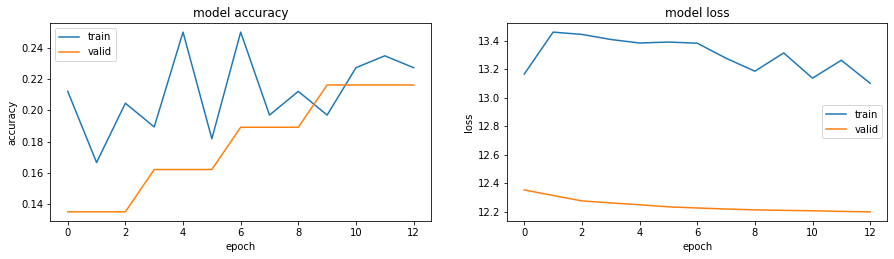


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.32432, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.32432

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.32432

Epoch 4: val_accuracy did not improve from 0.32432
Epoch 4: early stopping
2/2 [==============================] - 0s 15ms/step - loss: 2.9516 - accuracy: 0.3243

LOSS:	2.951615333557129 	 ACCURACY:	0.3243243098258972
[2.951615333557129, 0.3243243098258972]



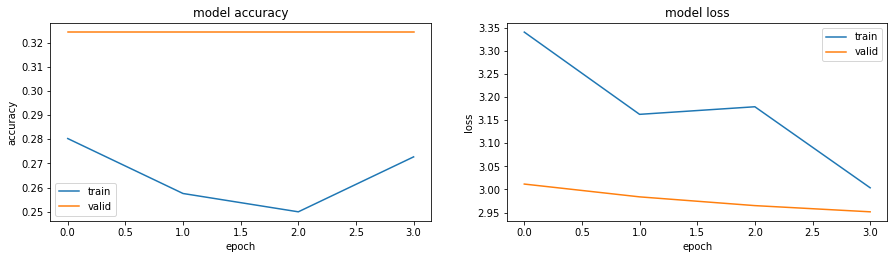


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 2.00e+00 3.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 50.1430 - accuracy: 0.0811

LOSS:	50.142967224121094 	 ACCURACY:	0.0810810774564743
[50.142967224121094, 0.0810810774564743]



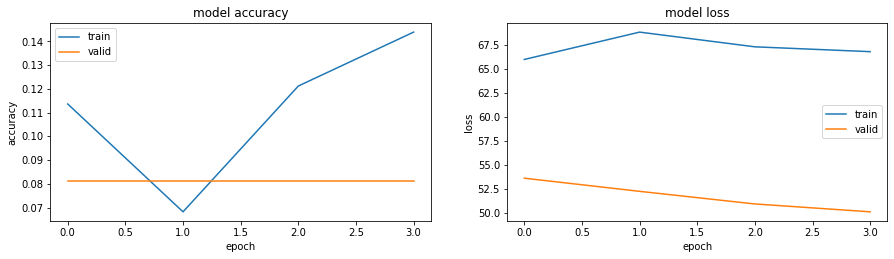


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy improved from 0.43243 to 0.56757, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.56757

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.56757

Epoch 7: val_accuracy did not improve from 0.56757
Epoch 7: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 91.8877 - accuracy: 0.5676

LOSS:	91.88772583007812 	 ACCURACY:	0.5675675868988037
[91.88772583007812, 0.5675675868988037]



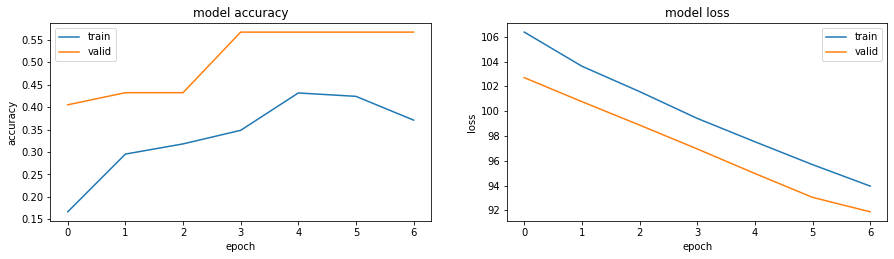


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 15ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.10811 to 0.13514, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.13514

Epoch 5: val_accuracy improved from 0.13514 to 0.21622, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.21622 to 0.27027, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.27027 to 0.29730, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.29730

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 9: val_accuracy did not improve from 0.29730

Epoch 10: val_accuracy did not improve from 0.29730
E

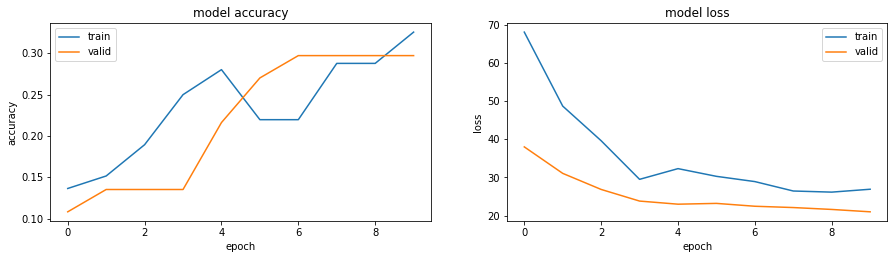


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.45946, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.45946

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.45946

Epoch 4: val_accuracy did not improve from 0.45946
Epoch 4: early stopping
2/2 [==============================] - 0s 14ms/step - loss: 40.8773 - accuracy: 0.4595

LOSS:	40.87733840942383 	 ACCURACY:	0.45945945382118225
[40.87733840942383, 0.45945945382118225]



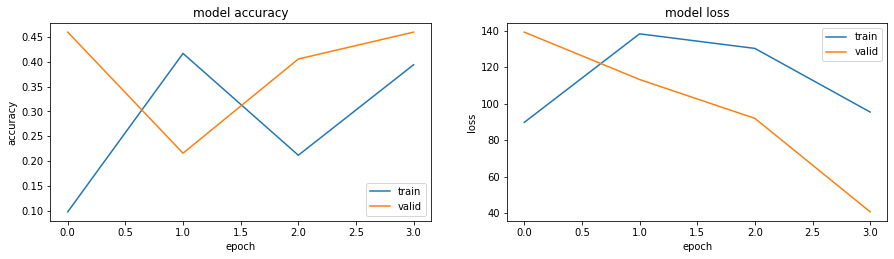


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 12.6778 - accuracy: 0.2162

LOSS:	12.677825927734375 	 ACCURACY:	0.21621622145175934
[12.677825927734375, 0.21621622145175934]



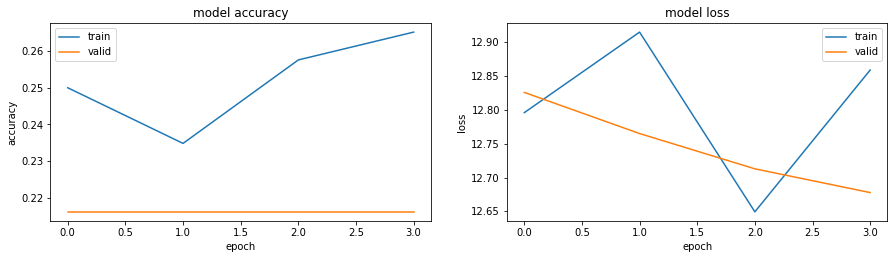


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: val_accuracy did not improve from 0.43243
Epoch 5: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 21.3178 - accuracy: 0.4324

LOSS:	21.31780433654785 	 ACCURACY:	0.4324324429035187
[21.31780433654785, 0.4324324429035187]



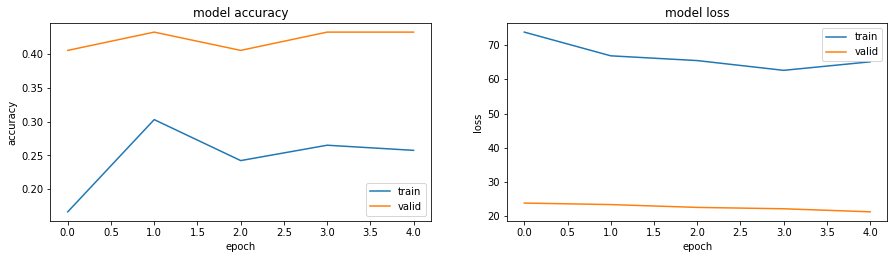


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.35135

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.35135

Epoch 4: val_accuracy improved from 0.35135 to 0.40541, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.40541 to 0.45946, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 7: val_accuracy did not improve from 0.45946

Epoch 8: val_accuracy did not improve from 0.45946
Epoch 8: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 23.8456 - accuracy: 0.4324

LOSS:	23.845556259155273 	 ACCURACY:	0.4324324429035187
[2

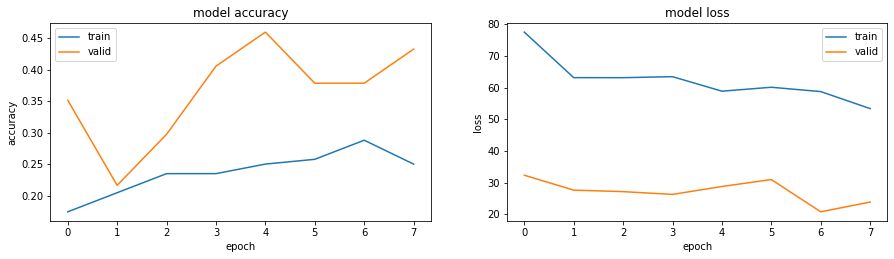


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: val_accuracy improved from 0.21622 to 0.24324, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.24324 to 0.27027, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.27027

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 6: val_accuracy did not improve from 0.27027

Epoch 7: val_accuracy did not improve from 0.27027
Epoch 7: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 30.3013 - accuracy: 0.2703

LOSS:	30.301315307617188 	 ACCURACY:	0.2702702581882477
[30.301315307617188, 0.2702702581882477]



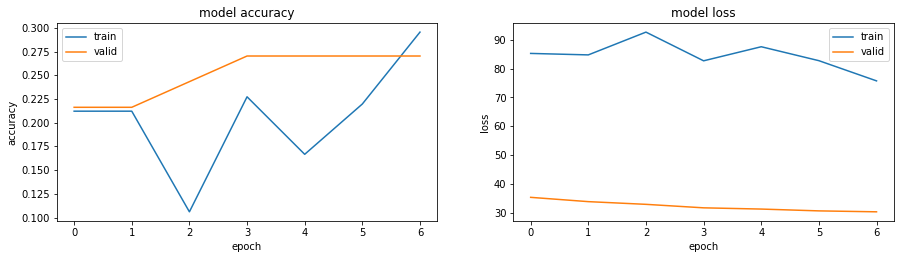


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 1.00e+00 5.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 15ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.45946, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.45946

Epoch 3: val_accuracy improved from 0.45946 to 0.51351, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.51351 to 0.54054, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.54054

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.54054

Epoch 7: val_accuracy improved from 0.54054 to 0.56757, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.56757

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 9: val_accuracy did not improve from 0.56757

Epoch 10: val_accuracy did not improve from 0.56757
Epoch 10: early stopping
2/2 [==

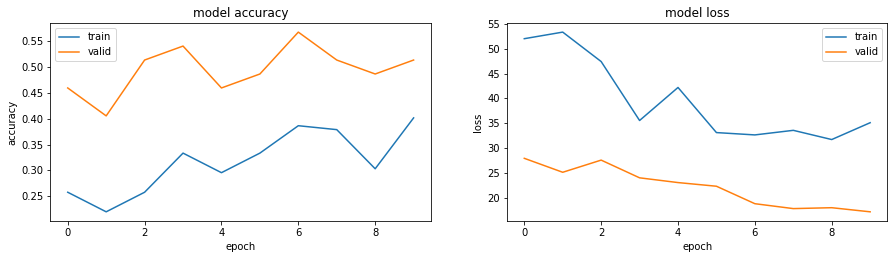


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 3.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 12ms/step - loss: 12.1143 - accuracy: 0.1622

LOSS:	12.114310264587402 	 ACCURACY:	0.1621621549129486
[12.114310264587402, 0.1621621549129486]



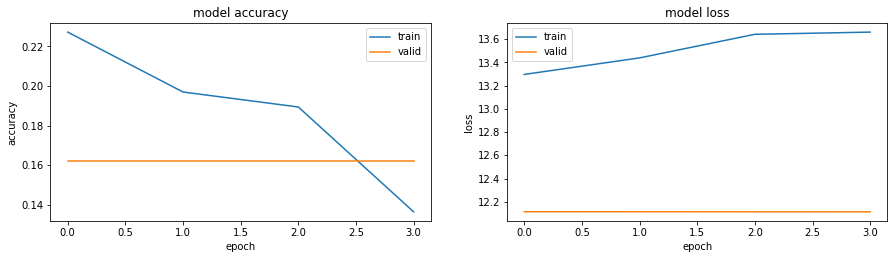


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 16.0675 - accuracy: 0.5676

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.43243 to 0.54054, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.54054

Epoch 7: val_accuracy improved from 0.54054 to 0.59459, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.59459

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.59459

Epoch 10: val_accuracy did not improve from 0.59459
Epoch 10: early stopping
2/2 [===

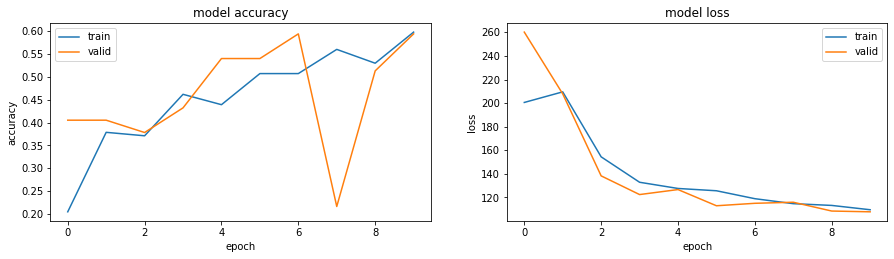


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 1.00e+00 5.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.54054, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.54054

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.54054

Epoch 4: val_accuracy did not improve from 0.54054
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 22.3762 - accuracy: 0.5135

LOSS:	22.37623405456543 	 ACCURACY:	0.5135135054588318
[22.37623405456543, 0.5135135054588318]



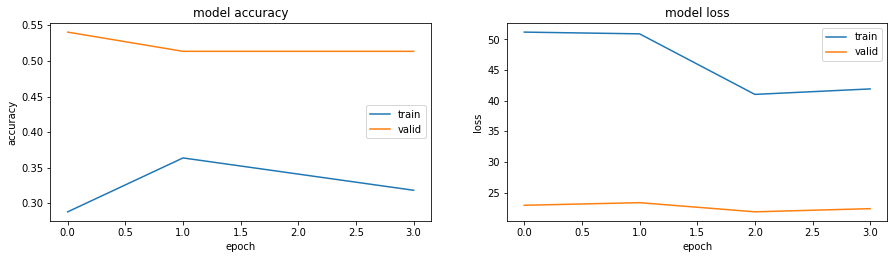


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.10811 to 0.21622, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.21622 to 0.29730, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.29730 to 0.37838, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.37838

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.37838

Epoch 7: val_accuracy did not improve from 0.37838
Epoch 7: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 102.1405 - accuracy: 0.3514

LOSS:	102.14048767089844 	 ACCURACY:	0.3513513505458832
[102.14048767089844, 0.3513513505458832]



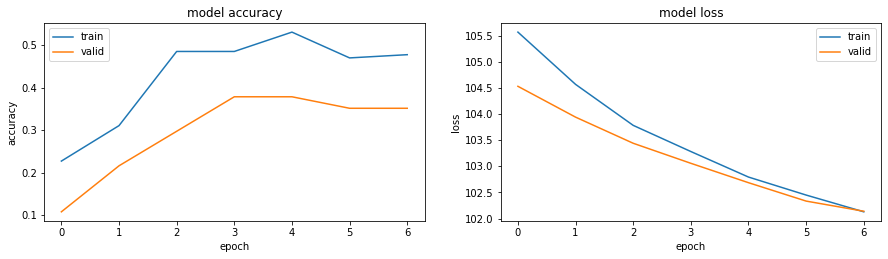


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 12.7150 - accuracy: 0.1081

LOSS:	12.71499252319336 	 ACCURACY:	0.10810811072587967
[12.71499252319336, 0.10810811072587967]



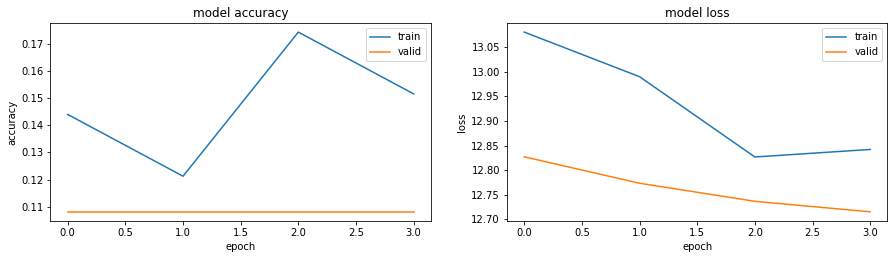


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 12.3825 - accuracy: 0.2162

LOSS:	12.382461547851562 	 ACCURACY:	0.21621622145175934
[12.382461547851562, 0.21621622145175934]



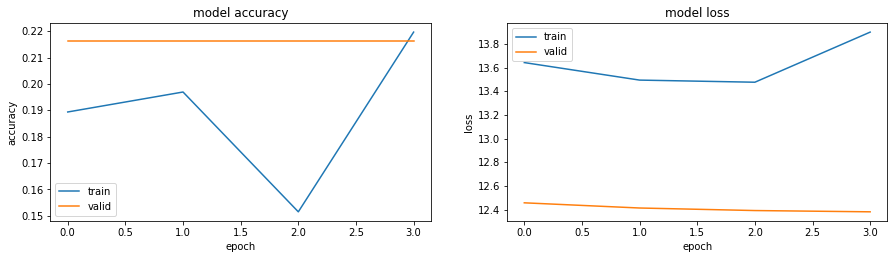


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.24324 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: val_accuracy did not improve from 0.43243
Epoch 5: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 155.8072 - accuracy: 0.4324

LOSS:	155.80715942382812 	 ACCURACY:	0.4324324429035187
[155.80715942382812, 0.4324324429035187]



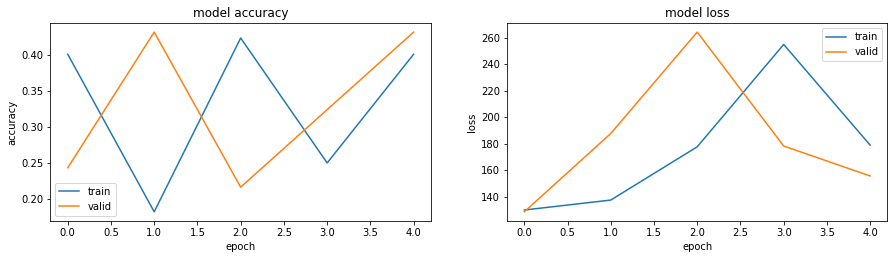


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.40541 to 0.59459, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.59459

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.59459

Epoch 5: val_accuracy did not improve from 0.59459
Epoch 5: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 26.7792 - accuracy: 0.5946

LOSS:	26.779170989990234 	 ACCURACY:	0.5945945978164673
[26.779170989990234, 0.5945945978164673]



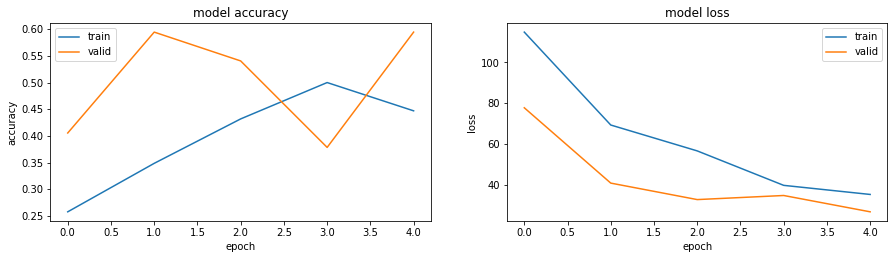


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy improved from 0.40541 to 0.48649, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.51351 to 0.56757, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.56757

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.56757

Epoch 9: val_accuracy did not improve from 0.56757
Epoch 9: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 2

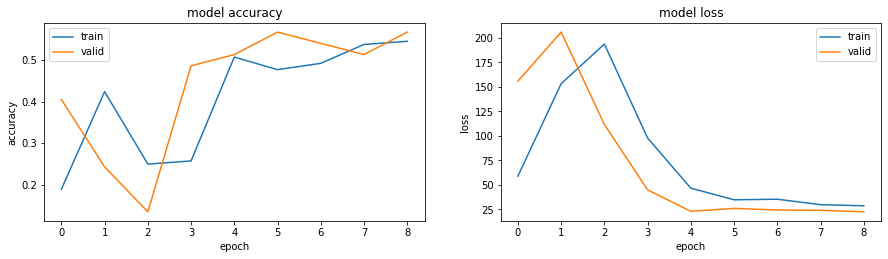


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 12ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.21622

Epoch 4: val_accuracy did not improve from 0.21622
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 74.7330 - accuracy: 0.2162

LOSS:	74.73303985595703 	 ACCURACY:	0.21621622145175934
[74.73303985595703, 0.21621622145175934]



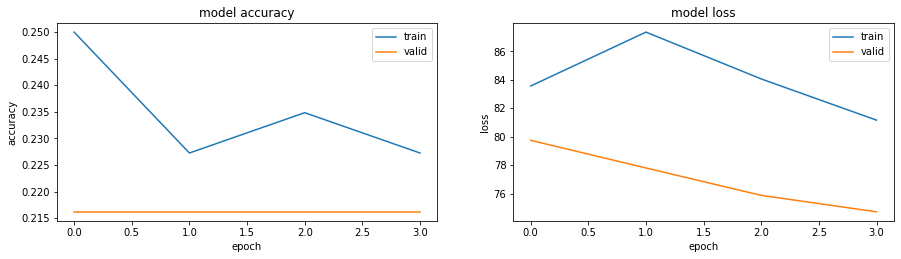


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 13ms/step - loss: 157.2134 - accuracy: 0.1081

LOSS:	157.2134246826172 	 ACCURACY:	0.10810811072587967
[157.2134246826172, 0.10810811072587967]



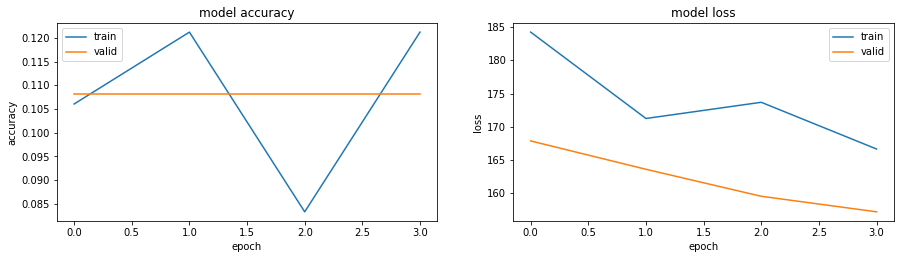


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 105.7835 - accuracy: 0.1892

LOSS:	105.78349304199219 	 ACCURACY:	0.18918919563293457
[105.78349304199219, 0.18918919563293457]



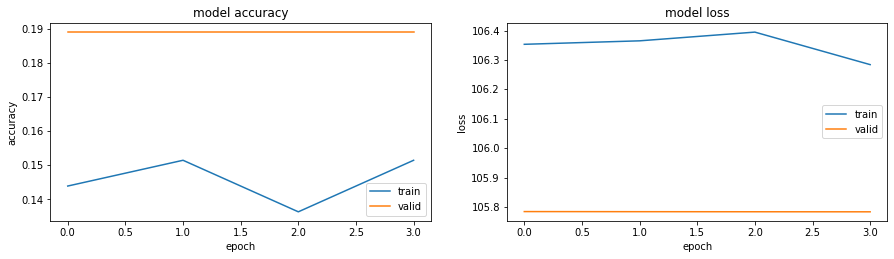


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.18919, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.18919

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy did not improve from 0.18919
Epoch 4: early stopping
2/2 [==============================] - 0s 19ms/step - loss: 29.3731 - accuracy: 0.1892

LOSS:	29.37310028076172 	 ACCURACY:	0.18918919563293457
[29.37310028076172, 0.18918919563293457]



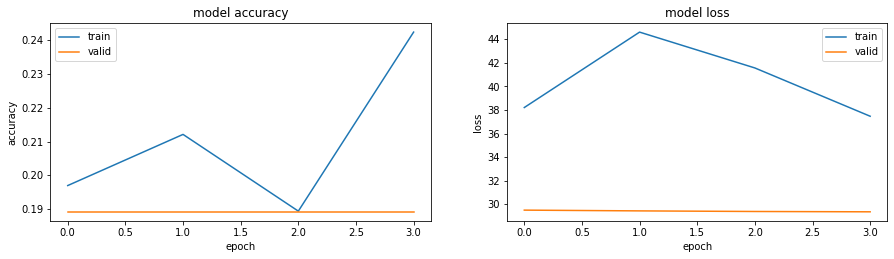


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.27027

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.27027

Epoch 4: val_accuracy did not improve from 0.27027
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 130.7102 - accuracy: 0.2703

LOSS:	130.71022033691406 	 ACCURACY:	0.2702702581882477
[130.71022033691406, 0.2702702581882477]



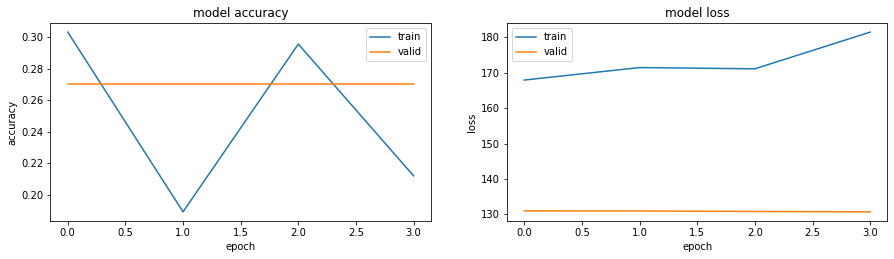


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.24324

Epoch 4: val_accuracy did not improve from 0.24324
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 139.9821 - accuracy: 0.2432

LOSS:	139.98214721679688 	 ACCURACY:	0.2432432472705841
[139.98214721679688, 0.2432432472705841]



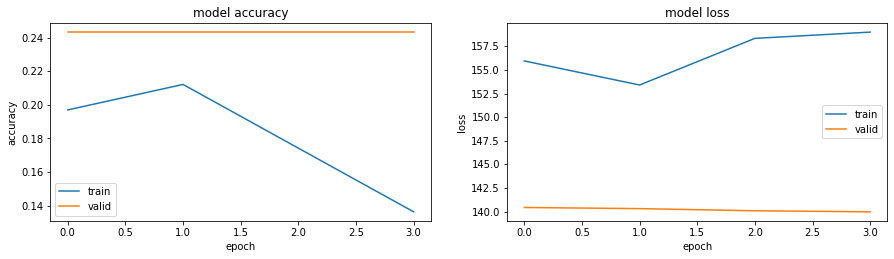


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.21622 to 0.35135, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.35135

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.35135

Epoch 5: val_accuracy improved from 0.35135 to 0.37838, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.37838

Epoch 7: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 7: val_accuracy did not improve from 0.37838

Epoch 8: val_accuracy did not improve from 0.37838
Epoch 8: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 2.6722 - accuracy: 0.3514

LOSS:	2.6722116470336914 	 ACCURACY:	0.3513513505458832
[

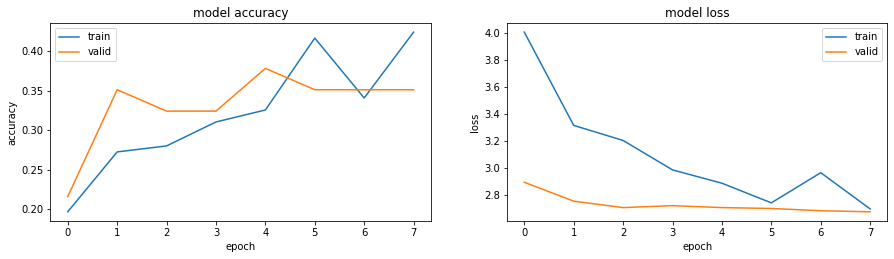


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 3.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 147.3109 - accuracy: 0.1081

LOSS:	147.31092834472656 	 ACCURACY:	0.10810811072587967
[147.31092834472656, 0.10810811072587967]



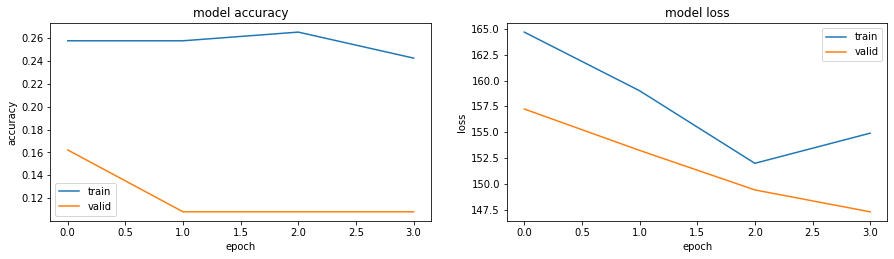


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.21622

Epoch 3: val_accuracy improved from 0.21622 to 0.24324, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.24324

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 5: val_accuracy did not improve from 0.24324

Epoch 6: val_accuracy did not improve from 0.24324
Epoch 6: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 31.4456 - accuracy: 0.2432

LOSS:	31.44562339782715 	 ACCURACY:	0.2432432472705841
[31.44562339782715, 0.2432432472705841]



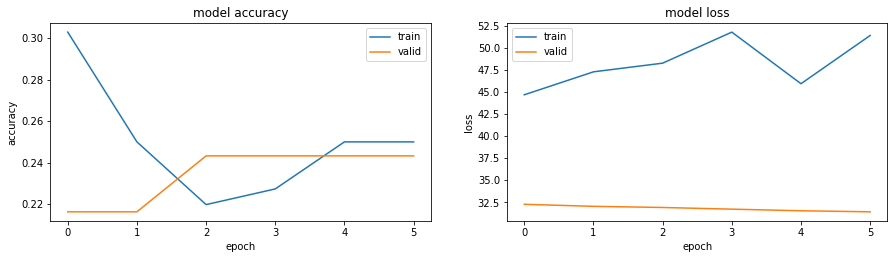


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: val_accuracy improved from 0.13514 to 0.40541, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.40541

Epoch 5: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.43243 to 0.56757, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.56757

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.56757

Epoch 9: val_accuracy improved from 0.56757 to 0.59459, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.59459

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

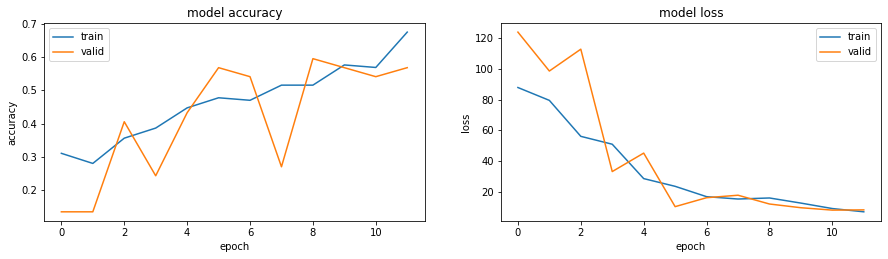


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.40541

Epoch 4: val_accuracy did not improve from 0.40541
Epoch 4: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 69.6186 - accuracy: 0.2973

LOSS:	69.61857604980469 	 ACCURACY:	0.29729729890823364
[69.61857604980469, 0.29729729890823364]



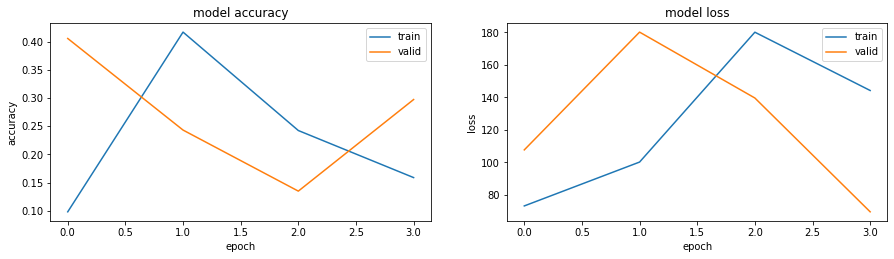


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 3.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.21622 to 0.24324, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.24324 to 0.29730, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.29730 to 0.37838, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.37838

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.37838

Epoch 7: val_accuracy did not improve from 0.37838
Epoch 7: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 123.0261 - accuracy: 0.3514

LOSS:	123.0261001586914 	 ACCURACY:	0.3513513505458832
[123.0261001586914, 0.3513513505458832]



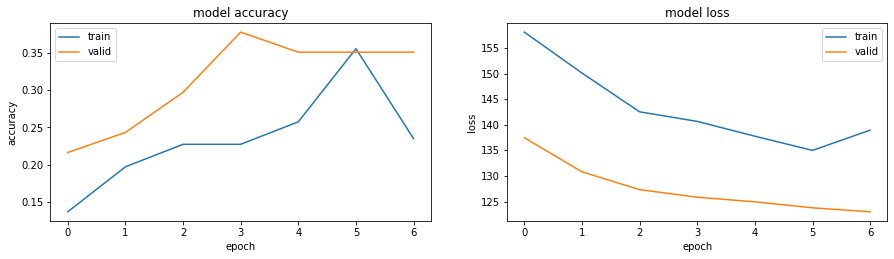


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08108

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.08108

Epoch 4: val_accuracy did not improve from 0.08108
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 69.2894 - accuracy: 0.0811

LOSS:	69.28938293457031 	 ACCURACY:	0.0810810774564743
[69.28938293457031, 0.0810810774564743]



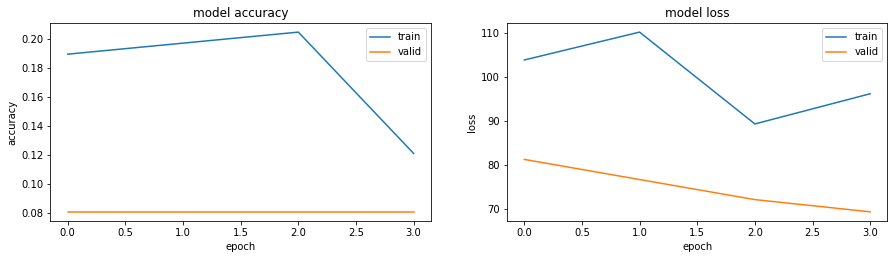


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.43243, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.45946

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.45946

Epoch 5: val_accuracy did not improve from 0.45946
Epoch 5: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 98.8652 - accuracy: 0.3784

LOSS:	98.86518859863281 	 ACCURACY:	0.37837839126586914
[98.86518859863281, 0.37837839126586914]



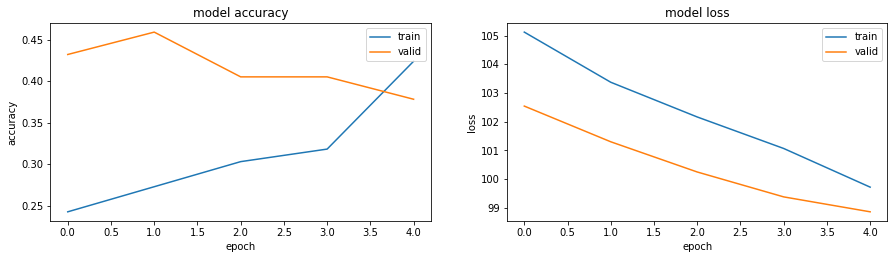


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.27027

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.27027

Epoch 4: val_accuracy did not improve from 0.27027
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 104.8294 - accuracy: 0.2703

LOSS:	104.82943725585938 	 ACCURACY:	0.2702702581882477
[104.82943725585938, 0.2702702581882477]



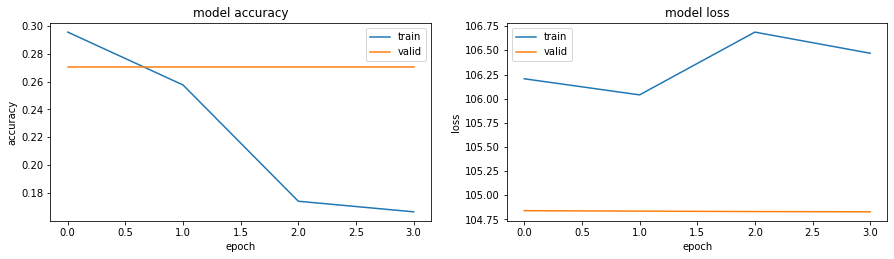


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 38.0712 - accuracy: 0.1351

LOSS:	38.07124328613281 	 ACCURACY:	0.13513512909412384
[38.07124328613281, 0.13513512909412384]



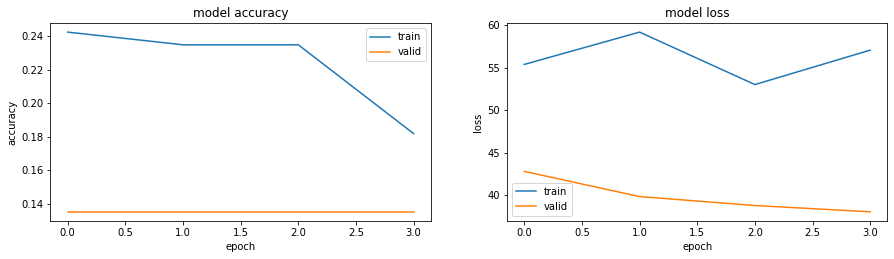


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 12.9355 - accuracy: 0.1622

LOSS:	12.93549919128418 	 ACCURACY:	0.1621621549129486
[12.93549919128418, 0.1621621549129486]



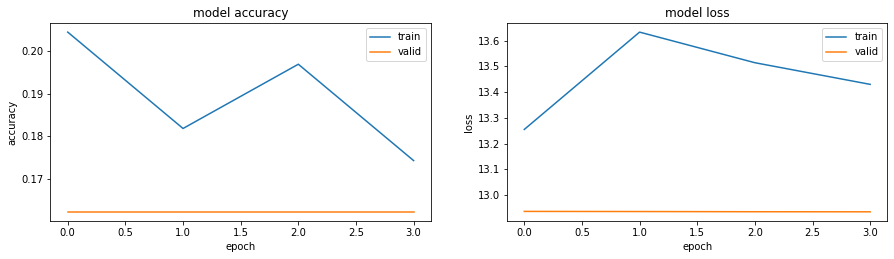


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.16216 to 0.18919, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.18919

Epoch 4: val_accuracy improved from 0.18919 to 0.27027, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.27027 to 0.32432, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.32432

Epoch 7: val_accuracy improved from 0.32432 to 0.37838, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.37838

Epoch 9: val_accuracy improved from 0.37838 to 0.40541, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.40541

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 11: val_accuracy did not improve from 0

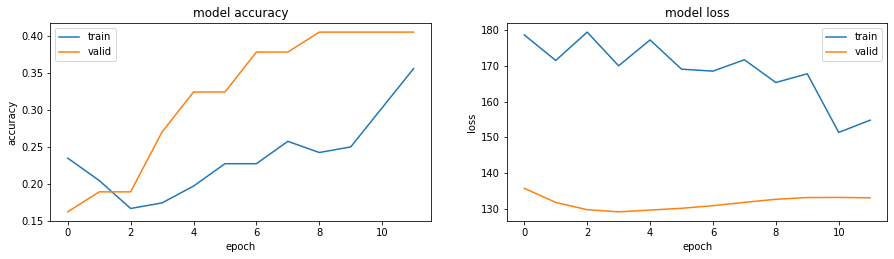


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.35135, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.35135

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.35135

Epoch 4: val_accuracy did not improve from 0.35135
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 25.9876 - accuracy: 0.2973

LOSS:	25.987627029418945 	 ACCURACY:	0.29729729890823364
[25.987627029418945, 0.29729729890823364]



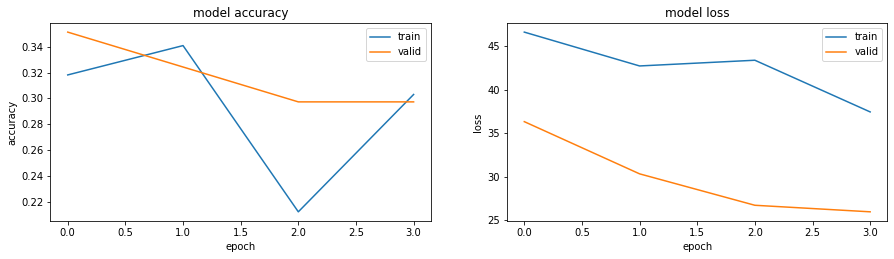


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.27027, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27027 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy improved from 0.43243 to 0.45946, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.45946

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.45946

Epoch 7: val_accuracy improved from 0.45946 to 0.51351, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.51351

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 9: val_accuracy did not improve from 0.51351

Epoch 10: val_accuracy did not improve from 0.51351
Epoch 10: early stopping
2/2 [==

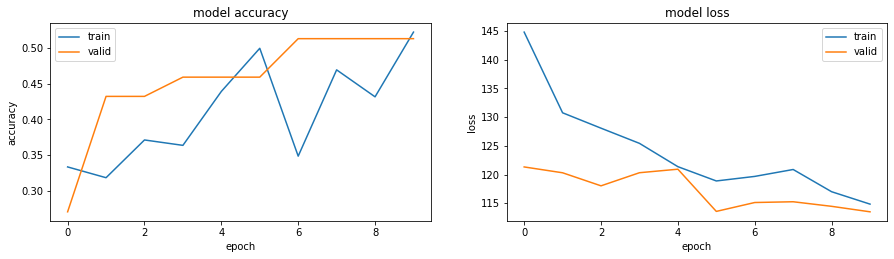


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 5ms/step - loss: 106.2007 - accuracy: 0.1081

LOSS:	106.20068359375 	 ACCURACY:	0.10810811072587967
[106.20068359375, 0.10810811072587967]



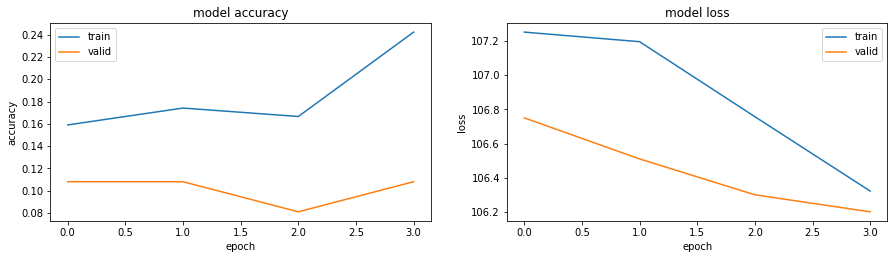


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.29730, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.29730

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.29730

Epoch 4: val_accuracy did not improve from 0.29730
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 105.4877 - accuracy: 0.2973

LOSS:	105.4876937866211 	 ACCURACY:	0.29729729890823364
[105.4876937866211, 0.29729729890823364]



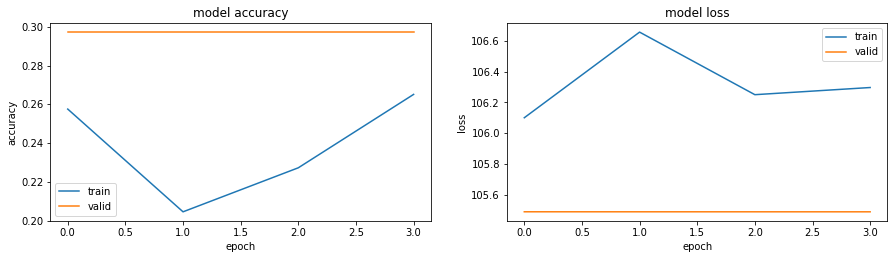


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 11ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 12.5627 - accuracy: 0.1622

LOSS:	12.562736511230469 	 ACCURACY:	0.1621621549129486
[12.562736511230469, 0.1621621549129486]



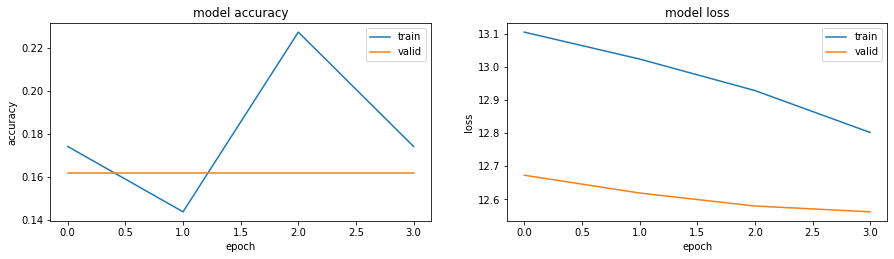


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 15ms/step - loss: 60.1264 - accuracy: 0.1081

LOSS:	60.126380920410156 	 ACCURACY:	0.10810811072587967
[60.126380920410156, 0.10810811072587967]



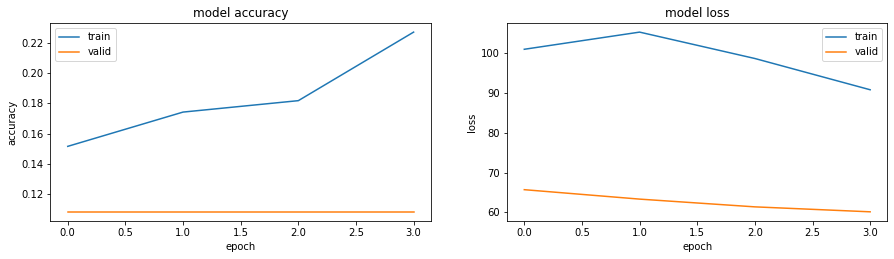


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 17ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 11ms/step - loss: 41.7537 - accuracy: 0.1622

LOSS:	41.75367736816406 	 ACCURACY:	0.1621621549129486
[41.75367736816406, 0.1621621549129486]



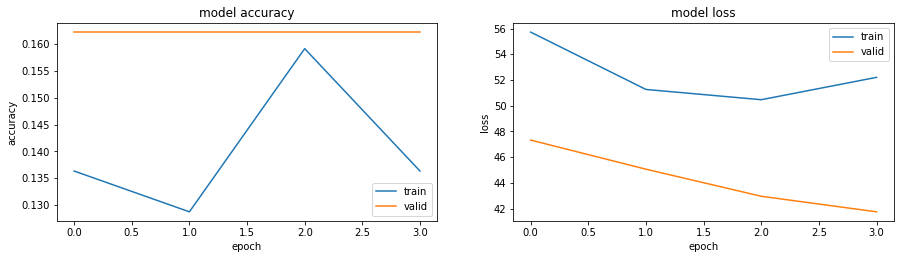


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 53.2387 - accuracy: 0.1622

LOSS:	53.23870849609375 	 ACCURACY:	0.1621621549129486
[53.23870849609375, 0.1621621549129486]



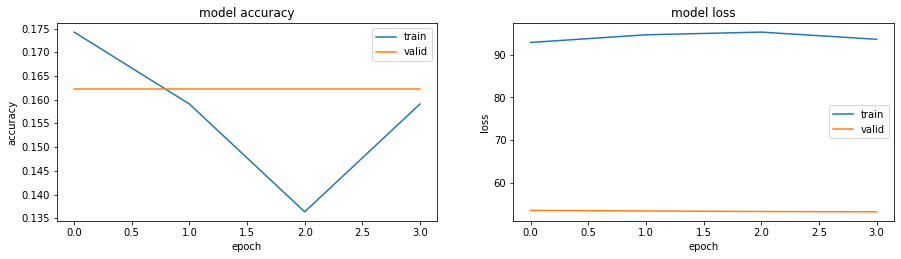


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 40.7794 - accuracy: 0.1351

LOSS:	40.77939987182617 	 ACCURACY:	0.13513512909412384
[40.77939987182617, 0.13513512909412384]



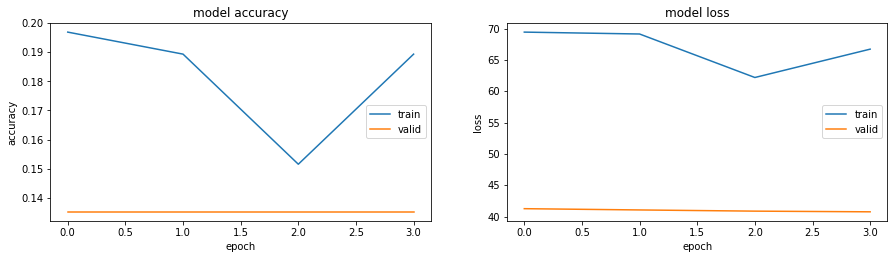


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 13ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13514

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.13514

Epoch 4: val_accuracy did not improve from 0.13514
Epoch 4: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 3.5882 - accuracy: 0.1351

LOSS:	3.588235855102539 	 ACCURACY:	0.13513512909412384
[3.588235855102539, 0.13513512909412384]



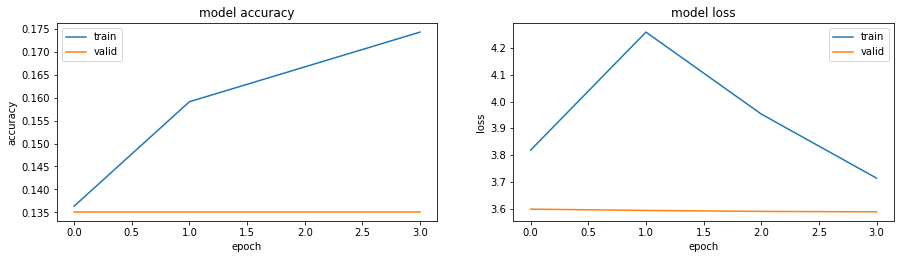


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 9ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.16216 to 0.43243, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.43243

Epoch 4: val_accuracy improved from 0.43243 to 0.54054, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.54054

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.54054

Epoch 7: val_accuracy did not improve from 0.54054
Epoch 7: early stopping
2/2 [==============================] - 0s 8ms/step - loss: 14.4257 - accuracy: 0.4595

LOSS:	14.425702095031738 	 ACCURACY:	0.45945945382118225
[14.425702095031738, 0.45945945382118225]



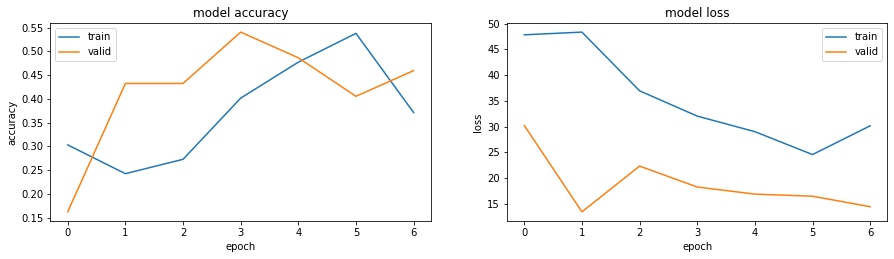


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.45946, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.45946

Epoch 3: val_accuracy improved from 0.45946 to 0.51351, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.51351

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.51351

Epoch 6: val_accuracy did not improve from 0.51351
Epoch 6: early stopping
2/2 [==============================] - 0s 19ms/step - loss: 21.6346 - accuracy: 0.4865

LOSS:	21.634626388549805 	 ACCURACY:	0.4864864945411682
[21.634626388549805, 0.4864864945411682]



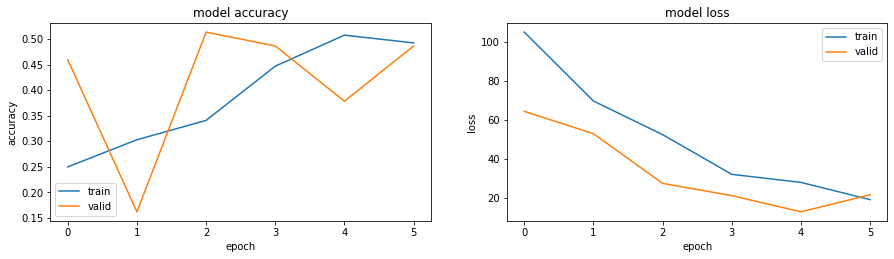


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
2/2 [==============================] - 0s 5ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.13514, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13514 to 0.27027, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.27027 to 0.45946, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.45946 to 0.54054, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.54054 to 0.56757, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.56757

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.56757

Epoch 8: val_accuracy improved from 0.56757 to 0.59459, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.59459

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accurac

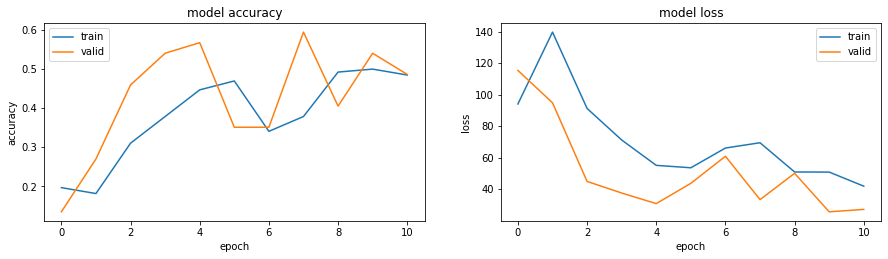


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 7ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.45946, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.45946

Epoch 3: val_accuracy improved from 0.45946 to 0.48649, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.48649 to 0.51351, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.51351

Epoch 6: val_accuracy improved from 0.51351 to 0.54054, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.54054

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.54054

Epoch 9: val_accuracy did not improve from 0.54054
Epoch 9: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 2.2040 - accuracy: 0.5135

LOSS:	2.203984022140503 	 ACCURACY:	0.51351350545883

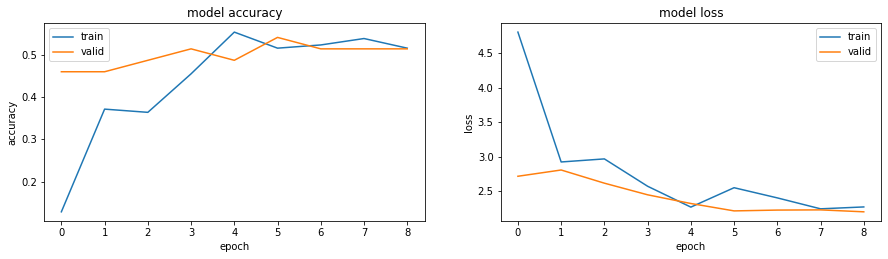


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 7.00e-01 1.28e+02 2.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.16216, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.16216

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.16216

Epoch 4: val_accuracy did not improve from 0.16216
Epoch 4: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 71.3306 - accuracy: 0.1622

LOSS:	71.33060455322266 	 ACCURACY:	0.1621621549129486
[71.33060455322266, 0.1621621549129486]



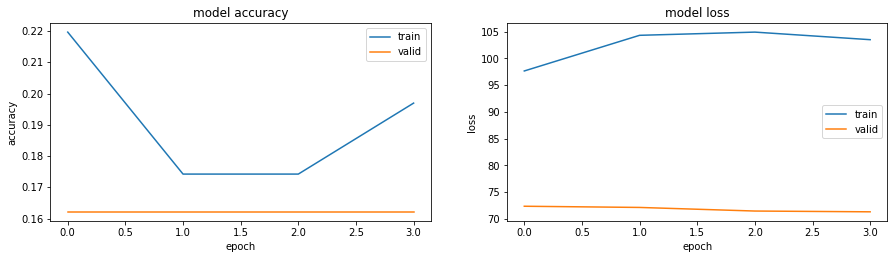


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
2/2 [==============================] - 0s 6ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.10811, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.10811

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.10811

Epoch 4: val_accuracy did not improve from 0.10811
Epoch 4: early stopping
2/2 [==============================] - 0s 6ms/step - loss: 46.7368 - accuracy: 0.1081

LOSS:	46.73676300048828 	 ACCURACY:	0.10810811072587967
[46.73676300048828, 0.10810811072587967]



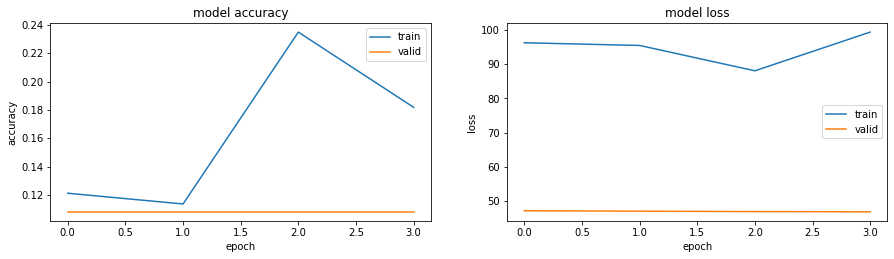


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.40541

Epoch 3: val_accuracy improved from 0.40541 to 0.43243, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.43243

Epoch 5: val_accuracy improved from 0.43243 to 0.48649, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.48649

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.48649

Epoch 8: val_accuracy did not improve from 0.48649
Epoch 8: early stopping
2/2 [==============================] - 0s 9ms/step - loss: 7.5288 - accuracy: 0.4865

LOSS:	7.528765678405762 	 ACCURACY:	0.4864864945411682
[7.528765678405762, 0.4864864945411682]



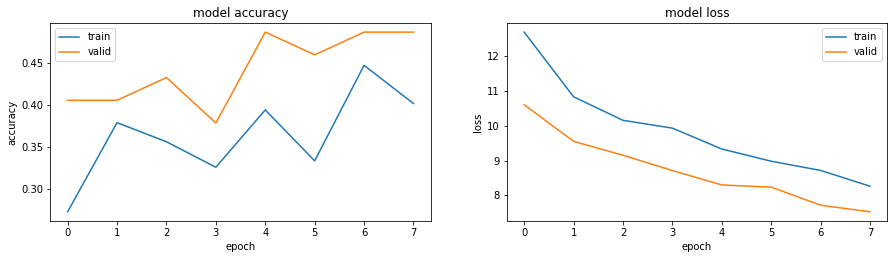


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]
2/2 [==============================] - 0s 10ms/step - loss: 107.8249 - accuracy: 0.5946

Epoch 1: val_accuracy improved from -inf to 0.24324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.24324

Epoch 3: val_accuracy improved from 0.24324 to 0.27027, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.27027

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.27027

Epoch 6: val_accuracy improved from 0.27027 to 0.29730, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.29730

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.29730

Epoch 9: val_accuracy did not improve from 0.29730
Epoch 9: early stopping
2/2 [==============================] - 0s 10ms/step - loss: 12.1241 - accuracy: 0.2973

LOS

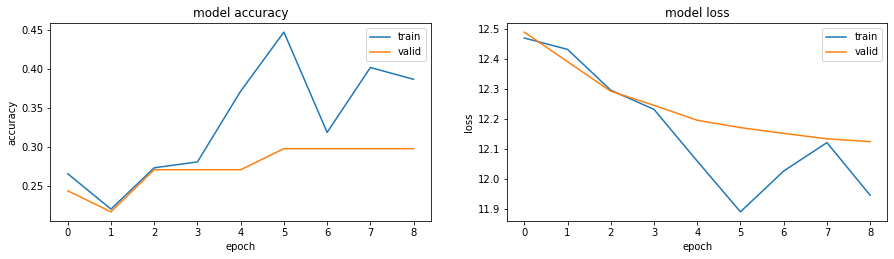

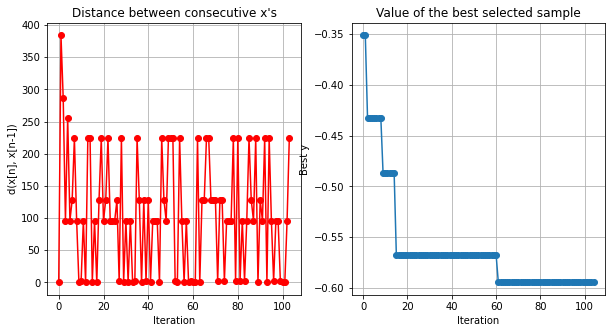

In [12]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('VGG_16_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],evaluation[1]))
  #print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [13]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	512.0
	learning_rate:	0.001
	l2:	0.1
	activation:	elu
	rate:	0.7
	batch:	32.0
 optim SGD
optimized accuracy: [0.5945946]


In [14]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('VGG_16_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test) 
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 265,221
Trainable params: 265,221
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 8ms/step - loss: 107.8249 - accuracy: 0.5946
Restored model, accuracy: 59.46%


In [15]:
best_model.evaluate(features_valid, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 107.8249 - accuracy: 0.5946


[107.82487487792969, 0.5945945978164673]

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, recall, precision, f1_score))

In [17]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Mon May 30 14:11:33 2022
Optimization completed:      NO,105 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           293.9829216003418 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition op

Test model with test data

In [18]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [20]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for test set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [21]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

1/1 [==============================] - 0s 50ms/step - loss: 103.7989 - accuracy: 0.3333
Restored model, accuracy: 33.33%


In [22]:
best_model.evaluate(features_test, y_test)

1/1 [==============================] - 0s 45ms/step - loss: 103.7989 - accuracy: 0.3333


[103.7989273071289, 0.3333333432674408]

In [23]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, recall, precision, f1_score))